In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn

In [ ]:
mot_dir = "/home/viplab/Research_DK/Mamba-MOT/GMTracker/data/MOT17/train"
print(os.listdir(mot_dir))

In [ ]:

def get_tracklet(gt_in, object_id):
    """
    Extract the tracklet for a given object ID.
    :param df: DataFrame containing the ground truth data.
    :param object_id: The ID of the object to extract the tracklet for.
    :return: DataFrame containing the tracklet.
    """
    tracklet  = []
    # tracklet.append(i) [for i in gt_in if gt_in[i] == object_id]
    for i in gt_in:
        # print(i)
        if i[1] == object_id:
            tracklet.append(i[2:6])
    return np.array(tracklet)

def tokenizer_frames(tracking, sliding_window):
    
    token  = [] 
    for i in range(sliding_window):
        current_bbox = tracking[i]
        # print("bounding box at {} frame : {}".format(i,current_bbox))
        # print("tracklet at Nth place is : ", tracking[sliding_window])
        delta = np.subtract(tracking[sliding_window], current_bbox)
        # print("delta is : ", delta)
        token.append(delta)
    
    return np.array(token)


for sequence in os.listdir(mot_dir):
    # seq = os.path.join(mot_dir, sequence)
    image_dir = os.path.join(mot_dir, sequence, "img1")
    gt_file = os.path.join(mot_dir, sequence, "gt", "gt.txt")
    # print(gt_file)

    gt_in = np.loadtxt(gt_file, delimiter = ",")

    # print(gt_in)

    ## Lets define 1 tracklet first
    object_id = 2 ## Tracklet with Object ID = 1
    tracklet = get_tracklet(gt_in, object_id)
    # print(" tracklet is : ", gt_in[tracklet])
    print(tracklet.shape)

    sliding_window = 50
    token = tokenizer_frames(tracklet, sliding_window)


    print("token shape is : ", token.shape)
    token = torch.tensor(token, dtype = torch.float32)

    input_dim = 4
    output_dim = 4
    embedding_layer = nn.Linear(input_dim, output_dim)

    embedded_tensor = embedding_layer(token)

    print(embedded_tensor)

    print(" shape of embedded tensot  : ", embedded_tensor.shape)
    
    break



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from mamba_ssm import Mamba

class BiMambaEncoder(nn.Module):
    def __init__(self, d_model, n_state):
        super(BiMambaEncoder, self).__init__()
        self.d_model = d_model
        
        self.mamba = Mamba(d_model, n_state)

        # Norm and feed-forward network layer
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x):
        # Residual connection of the original input
        residual = x
        
        # Forward Mamba
        x_norm = self.norm1(x)
        mamba_out_forward = self.mamba(x_norm)

        # Backward Mamba
        x_flip = torch.flip(x_norm, dims=[1])  # Flip Sequence
        mamba_out_backward = self.mamba(x_flip)
        mamba_out_backward = torch.flip(mamba_out_backward, dims=[1])  # Flip back

        # Combining forward and backward
        mamba_out = mamba_out_forward + mamba_out_backward
        
        mamba_out = self.norm2(mamba_out)
        ff_out = self.feed_forward(mamba_out)

        output = ff_out + residual
        return output

# Initialize and test the model
d_model = 4
n_state = 64
model = BiMambaEncoder(d_model, n_state).cuda()
x = torch.rand(1, 50, d_model).cuda()  # Analog input data: (batch_size, seq_len, feature_dim)
output = model(x)
print(output.shape)  # Mamba Out: (32, 100, 512)

## Initialize Tracklets

In [81]:
def initialize_tracklets(data):
    first_frame = int(np.min(data[:, 0]))
    first_frame_data = data[data[:, 0] == first_frame]
    # print(" first frame data : ", first_frame_data)

    tracklets = {}
    for row in first_frame_data:
        # print(" row is :", row)
        object_id = int(row[1])
        if object_id not in tracklets:
            tracklets[object_id] = [row[2:6]]
    return tracklets

### Update tracklets

In [82]:
def update_tracklets_for_frame(data, tracklets, frame):
    # unique_frames = np.unique(data[:, 0])


    # for frame in unique_frames:
    #     if frame == np.min(data[:, 0]):
    #         continue
    


    frame_data = data[data[:, 0] == frame]

    for row in frame_data:
        object_id = int(row[1])
        if object_id in tracklets:
            tracklets[object_id].append(row[2:6])
        else:
            ## Initialize a new tracklet if the object ID does not exist
            tracklets[object_id] = [row[2:6]]

    return tracklets
### Convert tracklet to numpy arrays

def convert_tracklets_to_numpy(tracklets):
    for object_id , tracklet_data in tracklets.items():
        tracklets[object_id] = np.array(tracklet_data)
    
    return tracklets



def load_data(filename):
    data = np.loadtxt(filename, delimiter=',', dtype=float)
    return data

In [83]:
filename = "/home/viplab/Research_DK/Mamba-MOT/GMTracker/data/MOT17/train/MOT17-02-SDP/gt/gt.txt"
data = load_data(filename)
tracklets = initialize_tracklets(data)

unique_frames = np.unique(data[:, 0])
for frame in unique_frames:
    if frame == 1:
        continue
    else:
        tracklets = update_tracklets_for_frame(data, tracklets, frame)
    # trackletsupdate_tracklets(data, tracklets) ## Updates all the tracklets at once. Can be changed to sending data per frame and updating the tracklets in a better way
tracklets = convert_tracklets_to_numpy(tracklets)


In [ ]:
tracklets.get(2).shape

## Tracklet Delta - Creating a Tokenizer function


In [ ]:
def compute_deltas(tracklet_data):
    # Compute deltas as described
    deltas = []
    for i in range(len(tracklet_data) - 1):
        delta = tracklet_data[i+1] - tracklet_data[i]
        deltas.append(delta)
    return np.array(deltas)


# Example tracklet data: shape (num_frames, 4) with columns [cx, cy, w, h]
# tracklet_data = np.array([
#     [100, 150, 50, 60],
#     [105, 155, 50, 60],
#     [110, 160, 50, 60]
# ])


# Create delta values for input sequence

window_size = 50
tracklet_data = tracklets.get(3)[:window_size+1]

tracklet_deltas = compute_deltas(tracklet_data)
print(tracklet_deltas.shape)

In [ ]:
import torch.nn as nn

class TemporalTokenEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(TemporalTokenEmbedding, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
    
    def forward(self, x):
        return self.embedding(x)

# Parameters
input_dim = tracklet_deltas.shape[1]  # Number of features in deltas (e.g., 4)
print(input_dim)
# Create and apply embedding layer
# embedding_layer = TemporalTokenEmbedding(input_dim, embedding_dim)
tracklet_delta_tensor = torch.tensor(tracklet_deltas, dtype=torch.float32).cuda()

## Steps to implement Bi-Mamba Encdoding Layer

#### Define Forward and Backward Mamba Modules: 
Implement the forward and backward Mamba modules.
#### Create a Bi-Mamba Block: 
Use the forward and backward modules to process input and apply normalization and MLP.
#### Assemble the Bi-Mamba Encoding Layer: 
Stack multiple Bi-Mamba blocks.

In [87]:
import torch
import torch.nn as nn
from mamba_ssm import Mamba



In [88]:

class BiMambaBlock(nn.Module):
    def __init__(self, d_model, n_state):
        super(BiMambaBlock, self).__init__()
        self.d_model = d_model
        
        self.mamba = Mamba(d_model, n_state)

        # Norm and feed-forward network layer
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x):
        # Residual connection of the original input
        residual = x
        
        # Forward Mamba
        x_norm = self.norm1(x)
        mamba_out_forward = self.mamba(x_norm)

        # Backward Mamba
        x_flip = torch.flip(x_norm, dims=[1])  # Flip Sequence
        mamba_out_backward = self.mamba(x_flip)
        mamba_out_backward = torch.flip(mamba_out_backward, dims=[1])  # Flip back
        print("mamba out backward shape :", mamba_out_backward.shape)
    
        # Combining forward and backward
        mamba_out = mamba_out_forward + mamba_out_backward
        mamba_out1  = self.norm2(mamba_out)
        print("mamba out 1 shape :", mamba_out1.shape)
    
        mamba_out2 = self.feed_forward(mamba_out)

        ff_out  = mamba_out1 + mamba_out2
        # output = ff_out + residualstart_index
        return ff_out


In [89]:
class BiMambaEncodingLayer(nn.Module):
    def __init__(self, embedding_dim, num_blocks):
        super(BiMambaEncodingLayer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_blocks = num_blocks
        # self.blocks = nn.ModuleList([BiMambaBlock(input_dim, embedding_dim) for _ in range(num_blocks)])
    
        self.mamba_block = BiMambaBlock(embedding_dim, embedding_dim)
    def forward(self, x):
        # print(" embedding dimension is : ", self.embedding_dim)
        # for block in self.blocks:
        x = self.mamba_block(x)
        # x = self.mamba_block(x)
        # x = self.mamba_block(x)
        
            # x = block(x)
            # print(" x shape in mamba block is : ", x.shape)
        
        return x

In [ ]:
class FullModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_blocks, prediction_dim):
        super(FullModel, self).__init__()
        self.temporal_token_embedding = TemporalTokenEmbedding(input_dim, embedding_dim)
        self.bi_mamba_encoding_layer = BiMambaEncodingLayer(embedding_dim, num_blocks)
        self.prediction_head = nn.Linear(embedding_dim, prediction_dim)
    
    def forward(self, x):
        x = self.temporal_token_embedding(x)
        print(" x shape is : ", x.shape)
        print(' type of x is : ', type(x))
        x  =  x.unsqueeze(0)
        print(" x after reshaping it is : ", x.shape)
        x = self.bi_mamba_encoding_layer(x)
        print(" x shape after  bimamba encoding layer is : ", x.shape)
        x = self.prediction_head(x)
        print(" x shape after  prediction head layer : ", x.shape)
        
        return x

# Example usage
input_dim = tracklet_delta_tensor.shape[1]  # Number of features in deltas (e.g., 4)
embedding_dim = 128 # Example embedding dimension
num_blocks = 4  # Number of Bi-Mamba blocks
prediction_dim = 4  # Number of predicted offsets

# Create and apply model
model = FullModel(input_dim, embedding_dim, num_blocks, prediction_dim).cuda()
predictions = model(tracklet_delta_tensor).cuda()
print(" shape of predictions : ", predictions.shape)

## Dataset class creation -0 copying DIffMOT Class for now

In [149]:

from torch.utils.data import Dataset

import glob
import numpy as np
import os



class MambaMOTDataset(Dataset):
    def __init__(self, path, interval=None):
        # self.config = 
        self.interval = interval + 1 ## Changed config interval to interval only

        self.trackers = {}
        self.images = {}
        self.nframes = {}
        self.ntrackers = {}

        self.nsamples = {}
        self.nS = 0

        self.nds = {}
        self.cds = {}
        if os.path.isdir(path):
            # if 'MOT' in path:
            self.seqs = ['MOT17-02-SDP', 'MOT17-11-SDP', 'MOT17-04-SDP', 'MOT17-05-SDP', 'MOT17-09-DPM', 'MOT17-11-FRCNN', 
                            'MOT17-10-DPM', 'MOT17-10-FRCNN', 'MOT17-09-SDP', 'MOT17-10-SDP', 'MOT17-11-DPM', 'MOT17-13-SDP', 
                            'MOT17-02-DPM', 'MOT17-13-FRCNN', 'MOT17-02-FRCNN', 'MOT17-13-DPM', 'MOT17-04-DPM', 'MOT17-05-FRCNN', 
                            'MOT17-09-FRCNN', 'MOT17-04-FRCNN', 'MOT17-05-DPM']
                
                
            # else:
                # self.seqs = [s for s in os.listdir(path)]
            self.seqs.sort()
            lastindex = 0
            for seq in self.seqs:
                
                # path_yo = os.path.join(path + "/" + seq, "img1/"))
                # print(path_yo)
                seq_path = glob.glob(os.path.join(path, seq, "img1", "*.txt"))
                # print(os.listdir(seq_path))
                # trackerPath = glob.glob(os.path.join(path + "/" + seq, "/img1/*.txt"))
                # print(seq_path)
                # print(" tracker path fiels are : ", seq_path)
                self.trackers[seq] = sorted((seq_path))
                self.ntrackers[seq] = len(self.trackers[seq])
                print(" number of tracks in sequence : {} : {}".format(seq, self.ntrackers[seq]))
                if 'MOT' in seq:
                    # print(" Yes Coming her?")
                    imagePath = os.path.join(path, '../../train', seq, "img1/*.*")
                else:
                    # print(" else")
                    imagePath = os.path.join(path, '../train', seq, "img1/*.*")
                self.images[seq] = sorted(glob.glob(imagePath))
                self.nframes[seq] = len(self.images[seq])
                print(" number of frames in sequence : {} : {}".format(seq, self.nframes[seq]))
                
                # print("images are : ", self.images)

                self.nsamples[seq] = {}
                for i, pa in enumerate(self.trackers[seq]):
                    self.nsamples[seq][i] = len(np.loadtxt(pa, dtype=np.float32).reshape(-1,7)) - self.interval
                    self.nS += self.nsamples[seq][i]


                self.nds[seq] = [x for x in self.nsamples[seq].values()]
                self.cds[seq] = [sum(self.nds[seq][:i]) + lastindex for i in range(len(self.nds[seq]))]
                lastindex = self.cds[seq][-1] + self.nds[seq][-1]

        print('=' * 80)
        print('dataset summary')
        print(self.nS)
        print('=' * 80)

    def __getitem__(self, files_index):

        for i, seq in enumerate(self.cds):
            if files_index >= self.cds[seq][0]:
                ds = seq
                for j, c in enumerate(self.cds[seq]):
                    if files_index >= c:
                        trk = j
                        start_index = c
                    else:
                        break
            else:
                break

        track_path = self.trackers[ds][trk]
        track_gt = np.loadtxt(track_path, dtype=np.float32)

        init_index = files_index - start_index

        cur_index = init_index + self.interval
        cur_gt = track_gt[cur_index]
        cur_bbox = cur_gt[2:6]

        boxes = [track_gt[init_index + tmp_ind][2:6] for tmp_ind in range(self.interval)]
        delt_boxes = [boxes[i+1] - boxes[i] for i in range(self.interval - 1)]
        conds = np.concatenate((np.array(boxes)[1:], np.array(delt_boxes)), axis=1)

        delt = cur_bbox - boxes[-1]
        ret = {"cur_gt": cur_gt, "cur_bbox": cur_bbox, "condition": conds, "delta_bbox": delt}

        return ret

    def __len__(self):
        return self.nS


In [ ]:
data_path = '/home/viplab/Research_DK/Mamba-MOT/GMTracker/data/MOT17/trackers_gt/train'

interval = 50
train_dataset = MambaMOTDataset(data_path, 50)

train_data_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=64,
            shuffle=True,
            num_workers= 2,
            pin_memory=True
        )

In [ ]:
for batch in train_data_loader:
    # print(" shape of batch is : ", batch)
    data = batch
    current_gt = data['cur_gt']
    current_bbox = data['cur_bbox']
    delta_bbox = data['delta_bbox']
    print("current GT shape :", current_gt.shape)
    print("delta shape : ", delta_bbox.shape)
    print("current bbox shape : ", current_bbox.shape)
    

In [4]:
import os
import cv2
import glob
model_type = "bi-mamba"
window_size = "variable"
root_dir = "datasets/sportsmot_publish/train_copy_testing"
# sequence_file = "visualizations/{}_{}/{}".format(model_type, window_size, root_dir.split("/")[1])
# saved_dir = os.listdir(sequence_main)
sequence_file = glob.glob("visualizations/{}_{}/{}".format(model_type, window_size, root_dir.split("/")[1] + '/*'))

sequence_main = [entry for entry in sequence_file if os.path.isdir(entry)]
print("sequence_main is : ", sequence_main)

for sequence in sequence_main:
    sequence_name = sequence.split("/")[-1]
    print(sequence_name)
# print(saved_dir)


sequence_main is :  ['visualizations/bi-mamba_variable/sportsmot_publish/v_2j7kLB-vEEk_c001', 'visualizations/bi-mamba_variable/sportsmot_publish/v_dChHNGIfm4Y_c003', 'visualizations/bi-mamba_variable/sportsmot_publish/v_1LwtoLPw2TU_c012', 'visualizations/bi-mamba_variable/sportsmot_publish/v_ApPxnw_Jffg_c015']
v_2j7kLB-vEEk_c001
v_dChHNGIfm4Y_c003
v_1LwtoLPw2TU_c012
v_ApPxnw_Jffg_c015


In [2]:

for sequence in os.listdir(sequence_main):
    print(" Reaching sequence : ", sequence)
    sequence_images = sorted(glob.glob(os.path.join(sequence_main, sequence)   +"/" +  "*.jpg"))
    print("sequences images are : ", sequence_images)
    # break
    print(" sequence images are : ", sequence_images[0])
    frame = cv2.imread(sequence_images[0])
    height, width, layers = frame.shape
    # cv2.imshow("frame", frame)
    # cv2.waitKey(5000)
    # print("frame is : ", frame)
    size = (width, height)
    output_video_name = "{}.mp4".format(
for sequence in os.listdir(sequence_main):
    print(" Reaching sequence : ", sequence)
    sequence_images = sorted(glob.glob(os.path.join(sequence_main, sequence)   +"/" +  "*.jpg"))
    print("sequences images are : ", sequence_images)
    # break
    print(" sequence images are : ", sequence_images[0])
    frame = cv2.imread(sequence_images[0])
    height, width, layers = frame.shape
    # cv2.imshow("frame", frame)
    # cv2.waitKey(5000)
    # print("frame is : ", frame)
    size = (width, height)
    output_video_name = "{}.mp4".format(sequence)
    print("output video name : ", output_video_name)
    output_video_path = os.path.join(sequence_main, output_video_name)
    
    # Define the video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    fps = 10  # Frames per second
    out = cv2.VideoWriter(output_video_path, fourcc, fps, size)
    output_vid = os.path.join(sequence_main, sequence) + ".mp4"
    
    for image in sequence_images:
        img = cv2.imread(image)
        out.write(img)
   
    out.release()     
        
    
    
    sequence)
    print("output video name : ", output_video_name)
    output_video_path = os.path.join(sequence_main, output_video_name)
    
    # Define the video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    fps = 10  # Frames per second
    out = cv2.VideoWriter(output_video_path, fourcc, fps, size)
    output_vid = os.path.join(sequence_main, sequence) + ".mp4"
    
    for image in sequence_images:
        img = cv2.imread(image)
        out.write(img)
   
    out.release()     
        
    
    
    

 Reaching sequence :  dancetrack0086
sequences images are :  ['visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000001.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000002.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000003.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000004.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000005.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000006.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000007.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000008.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000009.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000010.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000011.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/000012.jpg', 'visualizations/bi-mamba_variable/dancetrack/dancetrack0086/00

IndexError: list index out of range

In [3]:
import torch
# from iou_calc import giou_loss, ciou_loss_gpt, ciou_loss_perplexity
import iou_calc
# Example usage
pred_boxes = torch.tensor([[50, 50, 100, 100], [60, 60, 120, 120]], dtype=torch.float32)
# target_boxes = torch.tensor([[55, 55, 95, 95], [65, 65, 125, 125]], dtype=torch.float32)
target_boxes = torch.tensor([[110, 110, 155, 155], [135, 121, 176, 176]], dtype=torch.float32)

loss_ciou = iou_calc.ciou_loss_gpt(pred_boxes, target_boxes)
loss_ciou_p = iou_calc.ciou_loss_perplexity(pred_boxes, target_boxes)

loss_giou = iou_calc.giou_loss(pred_boxes, target_boxes)
print("CIoU Loss:", loss_ciou)
print("CIOU Loss with perplexity L: ", loss_ciou_p.mean())
print("GIoU Loss: ", loss_giou)

CIoU Loss: tensor(0.9425)
CIOU Loss with perplexity L:  tensor(0.9425)
GIoU Loss:  tensor(1.0036)


In [50]:

def compute_lr():
    d_model = 128
    current_step = 4000*10
    warmup_steps = 40000
    """Compute the learning rate using the formula."""
    scale = d_model ** -0.5
    step_factor = min(current_step ** -0.5, current_step * (warmup_steps ** -1.5))
    return scale * step_factor

compute_lr()

0.00044194173824159226

In [10]:
import time
current_time = time.localtime()
# print(current_time)
formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", current_time)
formatted_date = time.strftime("%d %B", current_time)
formatted_time = time.strftime("%H:%M:%S", current_time)

print(formatted_date)


time.struct_time(tm_year=2024, tm_mon=10, tm_mday=4, tm_hour=18, tm_min=9, tm_sec=1, tm_wday=4, tm_yday=278, tm_isdst=1)
04 October


In [2]:
#### This is the actual image  shape
actual_image_size  = [1080, 1440]
actual_img_h, actual_img_w = actual_image_size[0], actual_image_size[1]


## This is the YOLO output shape 
yolo_image_size = [800, 1440]
yolo_img_h, yolo_img_w = yolo_image_size[0], actual_image_size[1]

# scale = min(actual_image_size[0] / float(img_h), actual_image_size[1] / float(img_w))
scale = (actual_img_h/yolo_image_size[0], actual_img_w/float(yolo_image_size[1]))
print(scale)



(1.35, 1.0)


bounding boxes before :  [[541, 411, 629, 572], [836, 395, 917, 565], [650, 407, 720, 568], [467, 428, 537, 587], [366, 423, 440, 585], [711, 404, 797, 567], [361, 426, 421, 576], [966, 386, 1032, 564], [443, 395, 549, 567], [450, 417, 531, 570]]
 bounding boxes now are :  [(730, 554, 849, 772), (1128, 533, 1237, 762), (877, 549, 972, 766), (630, 577, 724, 792), (494, 571, 594, 789), (959, 545, 1075, 765), (487, 575, 568, 777), (1304, 521, 1393, 761), (598, 533, 741, 765), (607, 562, 716, 769)]
 image shaoe is :  (1080, 1440, 3)


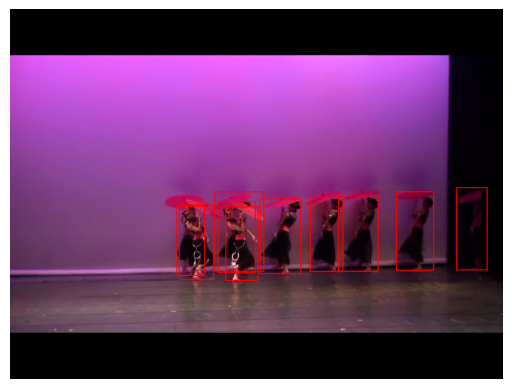

In [46]:
# bboxes  = [(462, 280, 462 + 164,  280 + 467), (718, 307, 718 + 222, 307 + 429), (572 , 229, 572+ 193,  229 + 569)]
# bboxes 

bboxes =  [[ 541,   411,    629 ,   572 ],
 [ 836 ,  395 , 917  , 565  ],
 [ 650  , 407 , 720 ,  568  ],
 [ 467 , 428,  537  ,  587 ],
 [ 366 , 423 , 440 , 585 ],
 [ 711 ,   404,  797 ,   567  ],
 [ 361 ,   426  , 421 ,   576  ],
 [ 966 ,  386, 1032 ,   564  ],
 [ 443 , 395 , 549 ,   567  ],
 [ 450 ,   417 ,  531 ,  570 ]]
# image_h, image_w = (800, 1440)
scale  = (1080/800, 1440/1440)



# Function to normalize bounding boxes
def normalize_bounding_boxes(bounding_boxes, original_width = 1440, original_height = 800):
    normalized_boxes = []
    for (x_min, y_min, x_max, y_max) in bounding_boxes:
        # Normalize coordinates
        norm_x_min = x_min / original_width
        norm_y_min = y_min / original_height
        norm_x_max = x_max / original_width
        norm_y_max = y_max / original_height
        normalized_boxes.append((norm_x_min, norm_y_min, norm_x_max, norm_y_max))
    return normalized_boxes

# Function to denormalize bounding boxes
def denormalize_bounding_boxes(normalized_boxes, new_width = 1440, new_height = 1080):
    denormalized_boxes = []
    for (norm_x_min, norm_y_min, norm_x_max, norm_y_max) in normalized_boxes:
        # Denormalize coordinates
        x_min = int(norm_x_min * new_width)
        y_min = int(norm_y_min * new_height)
        x_max = int(norm_x_max * new_width)
        y_max = int(norm_y_max * new_height)
        denormalized_boxes.append((x_min, y_min, x_max, y_max))
    return denormalized_boxes

import matplotlib.pyplot as plt
image_file = "datasets/dancetrack/val_new/dancetrack0041/img1/00000001.jpg"
import cv2


# Example function to draw bounding boxes on an image and show it
def draw_bounding_boxes(image_path, bounding_boxes):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    print(" image shaoe is : ", image.shape)
    # print(image)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib uses RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Loop through the bounding boxes and draw rectangles
    for box in bounding_boxes:
        # box is in the format (x_min, y_min, x_max, y_max)
        x_min, y_min, x_max, y_max = box
        # Draw rectangle on the image
        cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2)
    
    # Show the image using matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis for better visualization
    plt.show()
    
# Function to scale bounding boxes to the new aspect ratio
def scale_bounding_boxes(bounding_boxes, old_width = 1440, old_height = 800, new_width = 1440, new_height = 1080):
    scale_x = new_width / old_width
    scale_y = new_height / old_height
    scale_old = min(old_height / float(new_height), old_width / float(new_width))
    # print("scale is : ", scale_old)
    scaled_boxes = []
    # for (x_min, y_min, x_max, y_max) in bounding_boxes:
    #     # Scale the coordinates
    #     new_x_min = int(x_min * scale_x)
    #     new_y_min = int(y_min * scale_y)
    #     new_x_max = int(x_max * scale_x)
    #     new_y_max = int(y_max * scale_y)
    #     scaled_boxes.append((new_x_min, new_y_min, new_x_max, new_y_max))
    
    for (x_min, y_min, x_max, y_max) in bounding_boxes:
        # Scale the coordinates
        new_x_min = int(x_min / scale_old)
        new_y_min = int(y_min/  scale_old)
        new_x_max = int(x_max / scale_old)
        new_y_max = int(y_max / scale_old)
        scaled_boxes.append((new_x_min, new_y_min, new_x_max, new_y_max))
    
    return scaled_boxes


old_width = 1440
old_height = 800
new_width = 1440
new_height = 1080
# bboxes = normalize_bounding_boxes(bboxes)
# bboxes = denormalize_bounding_boxes(bboxes)
print("bounding boxes before : ", bboxes)

bboxes = scale_bounding_boxes(bboxes, old_width, old_height, new_width, new_height)
print(" bounding boxes now are : ", bboxes)
draw_bounding_boxes(image_file, bboxes)

In [3]:
bboxes  = [(462, 280, 462 + 164,  280 + 467), (718, 307, 718 + 222, 307 + 429), (572 , 229, 572+ 193,  229 + 569)]

bboxes_tlbr = bboxes
bboxes_tlbr
bboxes_scaled_tlbr = [[616, 378, 834, 1008], [957, 414, 1253, 993], [762, 309, 1020, 1077]]
bboxes_scaled_tlwh = [[616, 378, 834 - 616, 1008-378], [ 957, 414, 1253-957, 993-414], [762, 309, 1020-762, 1077-309]]
bboxes_scaled_tlwh


[[616, 378, 218, 630], [957, 414, 296, 579], [762, 309, 258, 768]]

In [9]:
import numpy as np
sequence = [[617, 379, 219, 630]]

sequence = np.array(sequence)
print("sequence is: ", sequence)
mean = 0
std_dev = 1
    # Generate Gaussian noise
noise = np.random.normal(mean, std_dev, sequence.shape)
    
    # Add the noise to the sequence
noisy_sequence = sequence + noise
print("noise sequence : ", noisy_sequence)

sequence is:  [[617 379 219 630]]
noise sequence :  [[617.31509425 378.62166881 220.18097249 631.77253753]]


In [11]:
import cv2
import numpy as np
import os
def draw_bounding_boxes(image, boxes, color, label):
    """
    Draw bounding boxes on the image.
    
    image: The image on which to draw the bounding boxes
    boxes: List of bounding boxes with format (x_min, y_min, width, height)
    color: Bounding box color (e.g., (255, 0, 0) for blue)
    label: Text label to display (e.g., 'Tracking' or 'Ground Truth')
    """
    for box in boxes:
        x_min, y_min, width, height = box[:4]
        # Draw rectangle on the image
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_min + width), int(y_min + height)), color, 2)
        # Display label near the top left corner of the bounding box
        # cv2.putText(image, label, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        label_with_id = f"{label} ID: {int(track_id)}"
        cv2.putText(image, " ",(int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


def visualize_tracking_to_video(sequence_folder, tracking_file, ground_truth_file, output_video_path, fps=30):
    """
    Visualizes tracking results and ground truth data on images and saves them as a video.
    
    sequence_folder: Folder containing image sequence
    tracking_file: Path to the file containing tracking data
    ground_truth_file: Path to the file containing ground truth data
    output_video_path: Path to save the resulting video
    fps: Frames per second for the output video
    """
    # Read the tracking and ground truth files
    tracking_data = np.loadtxt(tracking_file, delimiter=',')
    ground_truth_data = np.loadtxt(ground_truth_file, delimiter=',')
    
    frame_ids = set(tracking_data[:, 0])  # Set of unique frame_ids
    frame_ids = sorted(frame_ids)  # Sort frame_ids for sequential video

    # Get the size of the first image to define video properties
    first_img_path = os.path.join(sequence_folder, f'{int(frame_ids[0]):08d}.jpg')
    first_image = cv2.imread(first_img_path)
    if first_image is None:
        raise FileNotFoundError(f"Image not found: {first_img_path}")

    height, width, _ = first_image.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define the codec for MP4 format
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for frame_id in frame_ids:
        # Read the corresponding image
        img_path = os.path.join(sequence_folder, f'{int(frame_id):08d}.jpg')
        image = cv2.imread(img_path)
        if image is None:
            print(f"Image not found: {img_path}")
            continue

        # Extract tracking bounding boxes for the current frame
        tracking_boxes = tracking_data[tracking_data[:, 0] == frame_id]
        tracking_boxes = tracking_boxes[:, 1:6]  # Extract x_min, y_min, width, height

        # Extract ground truth bounding boxes for the current frame
        ground_truth_boxes = ground_truth_data[ground_truth_data[:, 0] == frame_id]
        ground_truth_boxes = ground_truth_boxes[:, 1:6]  # Extract x_min, y_min, width, height

        # Draw tracking boxes (in blue) and ground truth boxes (in green)
        draw_bounding_boxes(image, tracking_boxes, color=(0, 0, 0), label='Tracking')
        draw_bounding_boxes(image, ground_truth_boxes, color=(255, 0, 0), label='Ground Truth')

        # Write the frame to the video
        video_writer.write(image)

        print(f"Processed frame {int(frame_id)} and added to the video.")

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video_path}")# sequence_folder
# Example usage
sequence_folder = 'datasets/dancetrack/val/dancetrack0005/img1'  # Folder containing images
tracking_file = 'YOLOX_outputs/testing_oct7/testing_oct7_val/dancetrack0005.txt'  # File containing tracking data
ground_truth_file = 'datasets/dancetrack/val/dancetrack0005/gt/gt.txt'  # File containing ground truth data
output_folder = 'Oct_11_output_visualized_video_dancetrack0005.mp4'  # Folder to save visualized images

visualize_tracking_to_video(sequence_folder, tracking_file, ground_truth_file, output_folder)

Processed frame 1 and added to the video.
Processed frame 2 and added to the video.
Processed frame 3 and added to the video.
Processed frame 4 and added to the video.
Processed frame 5 and added to the video.
Processed frame 6 and added to the video.
Processed frame 7 and added to the video.
Processed frame 8 and added to the video.
Processed frame 9 and added to the video.
Processed frame 10 and added to the video.
Processed frame 11 and added to the video.
Processed frame 12 and added to the video.
Processed frame 13 and added to the video.
Processed frame 14 and added to the video.
Processed frame 15 and added to the video.
Processed frame 16 and added to the video.
Processed frame 17 and added to the video.
Processed frame 18 and added to the video.
Processed frame 19 and added to the video.
Processed frame 20 and added to the video.
Processed frame 21 and added to the video.
Processed frame 22 and added to the video.
Processed frame 23 and added to the video.
Processed frame 24 a

In [13]:
import numpy as np
import torch.nn as nn
import torch

input_seq = np.array([[[763, 309, 257, 768,],
 [727, 316, 301, 761,],
 [713, 322, 316, 755,],
 [628, 330, 406, 745,],
 [655, 355, 380, 718,],
 [609, 370, 464, 704,],
 [561, 385, 521, 684,],
 [521, 403, 569, 672,],
 [569, 443, 536, 630,],
 [743, 438, 327, 640]],
 [[536, 441, 312, 629],
 [458, 443, 426, 630],
 [487, 519, 420, 520],
 [530, 552, 371, 478],
 [549, 630, 343, 393],
 [472, 637, 392, 378],
 [461, 636, 438, 370],
 [514, 628, 408, 366],
 [537, 623, 315, 363],
 [818, 587, 131, 240]],
 
 [[957, 414, 296, 579],
 [957, 417, 319, 576],
 [963, 422, 308, 570],
 [952, 430, 322, 560],
 [950, 461, 302, 527],
 [849, 535, 441, 432],
 [720, 564, 587, 440],
 [763, 587, 549, 441],
 [840, 628, 448, 320],
 [893, 639, 388, 302]]], dtype = float)
 
input_seq_2 = np.array([[[763, 309, 257, 768],
 [727, 316, 301, 761],
 [713, 322, 316, 755],
 [628, 330, 406, 745],
 [655, 355, 380, 718]]], dtype = float)

from models_mamba import FullModelMambaBBox
input_size = 4
# Model parameters
# model_type = model_type
# dataset_name = dataset_name
input_size = 4  # Bounding box has 4 coordinates: [x, y, width, height]
hidden_size = 64 ## This one is used for LSTM NEtwork which I tried
output_size = 4  # Output also has 4 coordinates
num_layers = 4## For LSTM
embedding_dim = 128 ## For Mamba
num_blocks = 3 ## For Mamba
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# self.best_model_name  = "best_model_bbox_{}_variable_{}.pth".format(self.dataset_name, self.model_type)
best_model_name = "best_model_bbox_dancetrack_variable_bi-mamba_04_October.pth"

# print("model type is :",model_type)
# exit(0)

# if model_type == "bi-mamba" or model_type == "vanilla-mamba":
model = FullModelMambaBBox(input_size, embedding_dim, num_blocks, output_size, mamba_type =  "bi-mamba").to(device)
    # exit(0)

# print(" model to be loaded is : ", self.best_model_name)
model.load_state_dict(torch.load(best_model_name))  # Load the best model



<All keys matched successfully>

In [14]:

def denormalize_bbox(bboxes, img_size):
    """
    Denormalize bounding boxes to original scale. This converts it back to MOT Format as well. 
    """
    # bbox[:, 0] *= image_width  # Denormalize center_x
    # bbox[:, 1] *= image_height  # Denormalize center_y
    # bbox[:, 2] *= image_width  # Denormalize width
    # bbox[:, 3] *= image_height  # Denormalize height
    
    # # Convert back from (center_x, center_y, width, height) to (left, top, width, height)
    # bbox[:, 0] -= bbox[:, 2] / 2  # left = center_x - width/2
    # bbox[:, 1] -= bbox[:, 3] / 2  # top = center_y - height/2
    
    # return bbox
    # assert bboxes.shape[1:] == (4,), "Input bounding boxes should be in (center_x, center_y, width, height) format."
    # print("The image size used in DENORMALIZATION is: ", img_size)
    # Apply denormalization for each prediction
    img_h, img_w = img_size[0].item(), img_size[1].item()          ### SETTING IMAGE SIZE LIKE THIS IS NOT A MISTAKE
    print(" image height : {} and image width : {}".format(img_h, img_w))
    bboxes[:, 0] *= img_w   # Denormalize center_x
    bboxes[:, 1] *= img_h  # Denormalize center_y
    bboxes[:, 2] *= img_w   # Denormalize width
    bboxes[:, 3] *= img_h  # Denormalize height

    # Convert from (center_x, center_y, width, height) to (left, top, width, height)
    bboxes[:, 0] -= bboxes[:, 2] / 2  # left = center_x - width / 2
    bboxes[:, 1] -= bboxes[:, 3] / 2  # top = center_y - height / 2
    
    return bboxes
    
    
def normalize_yolo_bbox(bboxes, image_size):
    
    
    # print(" image size is : ", image_size)
    #### This function first converts the data from xywh format to YOLO Format, then nomralize it to process the model
    img_h, img_w = image_size[0], image_size[1]  # Image dimensions (height, width)

    # print("image height and width used for normalization is : {} , {}".format(img_h, img_w))
# Convert xywh to center-based YOLO format by adjusting the (x, y) to be at the center
    bboxes[..., 0] = bboxes[..., 0] + bboxes[..., 2] / 2  # Update x to center x
    bboxes[..., 1] = bboxes[..., 1] + bboxes[..., 3] / 2  # Update y to center y

    # Normalize the bounding boxes
    bboxes[..., 0] /= img_w  # Normalize center x
    bboxes[..., 1] /= img_h  # Normalize center y
    bboxes[..., 2] /= img_w  # Normalize width
    bboxes[..., 3] /= img_h  # Normalize height

    return bboxes
    

In [15]:
img_size = [torch.Tensor([1080]), torch.Tensor([1920])]
print(" tracklet detections shape : ", input_seq_2.shape)
print(" tracklet detections before normalization : \n", input_seq_2)
img_h, img_w = img_size[0].to(device), img_size[1].to(device)

tracklet_detections = normalize_yolo_bbox(input_seq_2, img_size)
# print(" tracklet before prediction is : ", tracklet_detections)
        
tracklet_detections = torch.from_numpy(tracklet_detections).float().to(device)
        
# print("tracklet detections are :", tracklet_detections)
with torch.no_grad():
    
    predictions = model(tracklet_detections)
    # print(" predictions type if : ", type(predictions))
    predicted_bbox  = predictions.cpu().numpy()
    
    print(" predicted_bbox is : ", predicted_bbox)
    # print("image size is : ", img_size)
    predicted_bbox = denormalize_bbox(predictions.cpu().numpy(), img_size)            
    print(" predicted box is :\n", predicted_bbox)
        

 tracklet detections shape :  (1, 5, 4)
 tracklet detections before normalization : 
 [[[763. 309. 257. 768.]
  [727. 316. 301. 761.]
  [713. 322. 316. 755.]
  [628. 330. 406. 745.]
  [655. 355. 380. 718.]]]
 predicted_bbox is :  [[0.15952136 0.44319636 0.4206604  0.5228706 ]]
 image height : 1080.0 and image width : 1920.0
 predicted box is :
 [[-97.55298 196.30194 807.66797 564.70026]]


In [4]:
import cv2
import numpy as np
import os
import glob

def draw_bounding_boxes(image, boxes, color, label):
    """
    Draw bounding boxes and track IDs on the image.
    
    image: The image on which to draw the bounding boxes
    boxes: List of bounding boxes with format (track_id, x_min, y_min, width, height)
    color: Bounding box color (e.g., (255, 0, 0) for blue)
    label: Text label to display (e.g., 'Tracking' or 'Ground Truth')
    """
    for box in boxes:
        track_id, x_min, y_min, width, height = box
        # Draw rectangle on the image
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_min + width), int(y_min + height)), color, 2)
        # Display track ID and label near the top left corner of the bounding box
        label_with_id = f"ID: {int(track_id)}"
        if label == "Tracking":
            cv2.putText(image, label_with_id, (int(x_min + width - 30), int(y_min ) - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        else:
            cv2.putText(image, label_with_id, (int(x_min- 30), int(y_min) - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


def visualize_tracking_to_video(sequence_folder, tracking_file, ground_truth_file, output_video_path, dataset, fps=30):
    """
    Visualizes tracking results and ground truth data on images and saves them as a video.
    
    sequence_folder: Folder containing image sequence
    tracking_file: Path to the file containing tracking data
    ground_truth_file: Path to the file containing ground truth data
    output_video_path: Path to save the resulting video
    fps: Frames per second for the output video
    """
    # Read the tracking and ground truth files
    tracking_data = np.loadtxt(tracking_file, delimiter=',')
    # ground_truth_data = np.loadtxt(ground_truth_file, delimiter=',')

    frame_ids = set(tracking_data[:, 0])  # Set of unique frame_ids
    frame_ids = sorted(frame_ids)  # Sort frame_ids for sequential video

    # Get the size of the first image to define video properties
    if dataset == "dancetrack":
        first_img_path = os.path.join(sequence_folder, f'{int(frame_ids[0]):08d}.jpg')
    else:
        first_img_path = os.path.join(sequence_folder, f'{int(frame_ids[0]):06d}.jpg')
    first_image = cv2.imread(first_img_path)
    if first_image is None:
        raise FileNotFoundError(f"Image not found: {first_img_path}")

    height, width, _ = first_image.shape

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define the codec for MP4 format
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for frame_id in frame_ids:
        # Read the corresponding image
        if dataset == "dancetrack":
            img_path = os.path.join(sequence_folder, f'{int(frame_id):08d}.jpg')
        else:
            img_path = os.path.join(sequence_folder, f'{int(frame_id):06d}.jpg')
        image = cv2.imread(img_path)
        if image is None:
            print(f"Image not found: {img_path}")
            continue

        # Extract tracking bounding boxes for the current frame
        tracking_boxes = tracking_data[tracking_data[:, 0] == frame_id]
        tracking_boxes = tracking_boxes[:, 1:6]  # Extract track_id, x_min, y_min, width, height

        # Extract ground truth bounding boxes for the current frame
        # ground_truth_boxes = ground_truth_data[ground_truth_data[:, 0] == frame_id]
        # ground_truth_boxes = ground_truth_boxes[:, 1:6]  # Extract track_id, x_min, y_min, width, height

        # Draw tracking boxes (in blue) and ground truth boxes (in green)
        draw_bounding_boxes(image, tracking_boxes, color=(0,0, 0), label='Tracking')
        # draw_bounding_boxes(image, ground_truth_boxes, color=(0, 255, 0), label='Ground Truth')

        # Write the frame to the video
        video_writer.write(image)

        # print(f"Processed frame {int(frame_id)} and added to the video.")

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video_path}")

# # Example usage
# sequence_folder = 'datasets/dancetrack/val/dancetrack0041/img1'  # Folder containing images
# tracking_file = 'YOLOX_outputs/testing_oct13_new_new/testing_oct13_new_new_val/dancetrack0041.txt'  # File containing tracking data
# ground_truth_file = 'datasets/dancetrack/val/dancetrack0041/gt/gt.txt'  # File containing ground truth data
# output_folder = 'Oct_13_new_new_output_visualized_video_dancetrack0041.mp4'  # Folder to save visualized images

dataset  = "sportsmot_publish"
# dataset  = "dancetrack"
experiment = "oct16_padding_fixed"
type = "val"

exp_path = experiment + "_" + type
GT_path = "datasets/{}/{}/".format(dataset, type)
track_path = "YOLOX_outputs/{}/{}_{}/".format(experiment, experiment, type)

GT_sequences = sorted(glob.glob(GT_path +"*/"))
print("GT Sequences are :", GT_sequences)
tracking_sequnces = sorted(glob.glob(track_path + "*.txt"))

print(tracking_sequnces)

# for GT_seq, track_seq in zip(GT_sequences, tracking_sequnces):
#     seq_folder = GT_seq + "img1"
#     gt_file = GT_seq + "gt/gt.txt"
#     # print("Seq folder is : ", seq_folder)
#     # print(" gt file is : ", gt_file)
#     # print("track sequence is :", track_seq)
#     output_folder = "visualizations/{}/{}".format(dataset, exp_path)
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder) 
#     output_file = os.path.join(output_folder, "{}.mp4".format(GT_seq.split("/")[-2]))
#     print(output_file)
#     visualize_tracking_to_video(seq_folder, track_seq, gt_file, output_file)


# # Example usage
# dataset  = "sportsmot_publish"
dataset = "dancetrack"
sequence_folder = 'datasets/{}/val/dancetrack0005/img1'.format(dataset)  # Folder containing images
ground_truth_file = 'datasets/{}/val/dancetrack0005/gt/gt.txt'.format(dataset)  # File containing ground truth data
tracking_file = '/home/viplab/Research_DK/Mamba-MOT/YOLOX_outputs/oct21_pose_estimate/oct21_pose_estimate_val/dancetrack0005.txt'  # File containing tracking data
# output_folder = 'bytetrack_vanilla-mamba_sports_oct20_val_v_00HRwkvvjtQ_c001.mp4'  # Folder to save visualized images
output_folder ="pose_estimate_iou_dancetrack0005.mp4"

# sequence_folder = 'datasets/sportsmot_publish/val/v_0kUtTtmLaJA_c005/img1'  # Folder containing images
# tracking_file = 'YOLOX_outputs/oct17_botsort/oct17_botsort_val/v_0kUtTtmLaJA_c005.txt'  # File containing tracking data
# ground_truth_file = 'datasets/sportsmot_publish/val/v_0kUtTtmLaJA_c005/gt/gt.txt'  # File containing ground truth data
# output_folder = 'oct17_botsort_v_0kUtTtmLaJA_c005.mp4'  # Folder to save visualized images

visualize_tracking_to_video(sequence_folder, tracking_file, ground_truth_file, output_folder, dataset)

GT Sequences are : ['datasets/sportsmot_publish/val/v_00HRwkvvjtQ_c001/', 'datasets/sportsmot_publish/val/v_00HRwkvvjtQ_c003/', 'datasets/sportsmot_publish/val/v_00HRwkvvjtQ_c005/', 'datasets/sportsmot_publish/val/v_00HRwkvvjtQ_c007/', 'datasets/sportsmot_publish/val/v_00HRwkvvjtQ_c008/', 'datasets/sportsmot_publish/val/v_00HRwkvvjtQ_c011/', 'datasets/sportsmot_publish/val/v_0kUtTtmLaJA_c004/', 'datasets/sportsmot_publish/val/v_0kUtTtmLaJA_c005/', 'datasets/sportsmot_publish/val/v_0kUtTtmLaJA_c006/', 'datasets/sportsmot_publish/val/v_0kUtTtmLaJA_c007/', 'datasets/sportsmot_publish/val/v_0kUtTtmLaJA_c008/', 'datasets/sportsmot_publish/val/v_0kUtTtmLaJA_c010/', 'datasets/sportsmot_publish/val/v_2QhNRucNC7E_c017/', 'datasets/sportsmot_publish/val/v_4-EmEtrturE_c009/', 'datasets/sportsmot_publish/val/v_4r8QL_wglzQ_c001/', 'datasets/sportsmot_publish/val/v_5ekaksddqrc_c001/', 'datasets/sportsmot_publish/val/v_5ekaksddqrc_c002/', 'datasets/sportsmot_publish/val/v_5ekaksddqrc_c003/', 'dataset

In [5]:
import cv2
import numpy as np
import os
import glob
import random

# Generate random colors for each unique track ID
def get_color(id):
    np.random.seed(id)  # Seed to get consistent color for each ID
    return tuple(np.random.randint(0, 255, 3).tolist())

def draw_bounding_boxes(image, boxes, label):
    """
    Draw bounding boxes and track IDs on the image with unique colors for each ID.
    
    image: The image on which to draw the bounding boxes
    boxes: List of bounding boxes with format (track_id, x_min, y_min, width, height)
    label: Text label to display (e.g., 'Tracking' or 'Ground Truth')
    """
    for box in boxes:
        track_id, x_min, y_min, width, height = box
        color = get_color(int(track_id))  # Assign color based on track_id
        
        # Draw rectangle on the image
        cv2.rectangle(image, (int(x_min), int(y_min)), 
                      (int(x_min + width), int(y_min + height)), color, 2)
        
        # Display track ID and label near the top left corner of the bounding box
        label_with_id = f"ID: {int(track_id)}"
        cv2.putText(image, label_with_id, 
                    (int(x_min), int(y_min - 10)), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

def visualize_tracking_to_video(sequence_folder, tracking_file, output_video_path, fps=20):
    """
    Visualizes tracking results and ground truth data on images and saves them as a video.
    
    sequence_folder: Folder containing image sequence
    tracking_file: Path to the file containing tracking data
    output_video_path: Path to save the resulting video
    fps: Frames per second for the output video
    """
    tracking_data = np.loadtxt(tracking_file, delimiter=',')
    frame_ids = sorted(set(tracking_data[:, 0]))  # Unique frame IDs

    first_img_path = os.path.join(sequence_folder, f'{int(frame_ids[0]):08d}.jpg')
    first_image = cv2.imread(first_img_path)
    if first_image is None:
        raise FileNotFoundError(f"Image not found: {first_img_path}")

    height, width, _ = first_image.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for frame_id in frame_ids:
        img_path = os.path.join(sequence_folder, f'{int(frame_id):08d}.jpg')
        image = cv2.imread(img_path)
        if image is None:
            print(f"Image not found: {img_path}")
            continue

        tracking_boxes = tracking_data[tracking_data[:, 0] == frame_id]
        tracking_boxes = tracking_boxes[:, 1:6]

        draw_bounding_boxes(image, tracking_boxes, label='Tracking')
        video_writer.write(image)

    video_writer.release()
    print(f"Video saved to {output_video_path}")

# Example usage
dataset = "dancetrack"
# dataset = "sportsmot_publish"
experiment = "oct21_pose_estimate"
type = "val"
exp_path = experiment + "_" + type

GT_path = f"datasets/{dataset}/{type}/"
track_path = f"YOLOX_outputs/{experiment}/{experiment}_{type}/"
print("track path is : ", track_path)

GT_sequences = sorted(glob.glob(GT_path + "*/"))
tracking_sequences = sorted(glob.glob(track_path + "*.txt"))

for GT_seq, track_seq in zip(GT_sequences, tracking_sequences):
    seq_folder = GT_seq + "img1"
    output_folder = f"visualizations/{dataset}/{exp_path}"
    os.makedirs(output_folder, exist_ok=True)
    
    output_file = os.path.join(output_folder, f"{GT_seq.split('/')[-2]}.mp4")
    print(output_file)
    visualize_tracking_to_video(seq_folder, track_seq, output_file)


track path is :  YOLOX_outputs/oct21_pose_estimate/oct21_pose_estimate_val/
visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0004.mp4
Video saved to visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0004.mp4
visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0005.mp4
Video saved to visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0005.mp4
visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0007.mp4
Video saved to visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0007.mp4
visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0010.mp4
Video saved to visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0010.mp4
visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0014.mp4
Video saved to visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0014.mp4
visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0018.mp4
Video saved to visualizations/dancetrack/oct21_pose_estimate_val/dancetrack0018.mp4
visual

In [1]:
import torch

targets = torch.Tensor([[0.4417, 0.6292, 0.1000, 0.3176],
        [0.7979, 0.6162, 0.0854, 0.3546],
        [0.5172, 0.4870, 0.1448, 0.7204],
        [0.1477, 0.5444, 0.1797, 0.5333],
        [0.2074, 0.6646, 0.1992, 0.1847],
        [0.7973, 0.5229, 0.0914, 0.4792],
        [0.5875, 0.7319, 0.0750, 0.2667],
        [0.5445, 0.6394, 0.0932, 0.3065],
        [0.2180, 0.6750, 0.0526, 0.2815],
        [0.1424, 0.4583, 0.0891, 0.2444],
        [0.7215, 0.5257, 0.0805, 0.4375],
        [0.5365, 0.6269, 0.0635, 0.2574],
        [0.4177, 0.6648, 0.0625, 0.3463],
        [0.5543, 0.6146, 0.0898, 0.4264],
        [0.5680, 0.4597, 0.2719, 0.3417],
        [0.7237, 0.6657, 0.0724, 0.3241],
        [0.3271, 0.6352, 0.0740, 0.5630],
        [0.5049, 0.5810, 0.1568, 0.5009],
        [0.6917, 0.6088, 0.0667, 0.2954],
        [0.4066, 0.5299, 0.0758, 0.4764],
        [0.3224, 0.6213, 0.0906, 0.3259],
        [0.6201, 0.6292, 0.0880, 0.3083],
        [0.5604, 0.6148, 0.0427, 0.2167],
        [0.4247, 0.5042, 0.0682, 0.2935],
        [0.3003, 0.6296, 0.0641, 0.3130],
        [0.4875, 0.6153, 0.0594, 0.2657],
        [0.3667, 0.5037, 0.1125, 0.3500],
        [0.5211, 0.5917, 0.1214, 0.4815],
        [0.4086, 0.6407, 0.0901, 0.2685],
        [0.3854, 0.6079, 0.0562, 0.2528],
        [0.3219, 0.6407, 0.1115, 0.2926],
        [0.5758, 0.5032, 0.0724, 0.3676],
        [0.2701, 0.6296, 0.1339, 0.4222],
        [0.6073, 0.6282, 0.0698, 0.2398],
        [0.5661, 0.4264, 0.0542, 0.2343],
        [0.3349, 0.4514, 0.0708, 0.2491],
        [0.3398, 0.6306, 0.1047, 0.3370],
        [0.6719, 0.5410, 0.0688, 0.2042],
        [0.5154, 0.6856, 0.0797, 0.2583],
        [0.6344, 0.5840, 0.0750, 0.4181],
        [0.7703, 0.6301, 0.1083, 0.2361],
        [0.5115, 0.6741, 0.0521, 0.3241],
        [0.5263, 0.5699, 0.0911, 0.2750],
        [0.3086, 0.5875, 0.1406, 0.5917],
        [0.7018, 0.5069, 0.1943, 0.5454],
        [0.4143, 0.5764, 0.1630, 0.2676]])


predictions = torch.Tensor([[8.9982e-01, 6.4929e-01, 1.2879e-01, 3.3259e-01],
        [9.0454e-01, 6.5274e-01, 1.2733e-01, 3.2331e-01],
        [9.0587e-01, 6.4959e-01, 1.1953e-01, 3.2660e-01],
        [9.0787e-01, 6.4968e-01, 1.2170e-01, 3.2706e-01],
        [9.0944e-01, 6.4790e-01, 1.1377e-01, 3.2839e-01],
        [9.0979e-01, 6.5252e-01, 1.0622e-01, 3.1827e-01],
        [9.0949e-01, 6.5670e-01, 1.0173e-01, 3.0850e-01],
        [9.0938e-01, 6.5954e-01, 9.3391e-02, 3.0739e-01],
        [9.0959e-01, 6.5701e-01, 9.1144e-02, 3.0957e-01],
        [9.0974e-01, 6.5544e-01, 8.5365e-02, 3.0047e-01],
        [8.9379e-01, 6.4229e-01, 1.2362e-01, 3.7139e-01],
        [8.9381e-01, 6.4150e-01, 1.2026e-01, 3.7574e-01],
        [8.9721e-01, 6.4377e-01, 1.1903e-01, 3.7259e-01],
        [9.0069e-01, 6.3704e-01, 1.1583e-01, 3.8303e-01],
        [9.1121e-01, 6.5223e-01, 1.1855e-01, 3.5684e-01],
        [7.4152e-01, 6.7323e-01, 1.4724e-01, 2.2586e-01],
        [1.0000e+00, 1.0000e+00, 7.6669e-16, 0.0000e+00],
        [9.9983e-01, 8.6518e-01, 1.9134e-14, 4.0215e-13],
        [9.3445e-01, 6.6616e-01, 2.1737e-01, 4.0768e-01],
        [9.0264e-01, 6.7874e-01, 1.1040e-01, 2.9046e-01],
        [9.0210e-01, 6.8808e-01, 1.1453e-01, 2.8597e-01],
        [9.0271e-01, 6.7918e-01, 1.1540e-01, 2.8749e-01],
        [9.0388e-01, 6.7800e-01, 1.1087e-01, 3.0279e-01],
        [9.0308e-01, 6.7106e-01, 1.1532e-01, 3.0982e-01],
        [9.0291e-01, 6.5967e-01, 1.1602e-01, 3.3260e-01],
        [8.9992e-01, 6.4609e-01, 1.2876e-01, 3.6104e-01],
        [9.0248e-01, 6.3385e-01, 1.4261e-01, 3.8013e-01],
        [9.0413e-01, 6.2935e-01, 1.4200e-01, 3.8424e-01],
        [9.0388e-01, 6.2739e-01, 1.4308e-01, 3.8270e-01],
        [9.0404e-01, 6.2898e-01, 1.4680e-01, 3.7716e-01],
        [9.0410e-01, 6.4734e-01, 1.5090e-01, 3.4935e-01],
        [8.9953e-01, 6.5360e-01, 1.6499e-01, 3.3485e-01],
        [8.9518e-01, 6.5996e-01, 1.5933e-01, 3.2046e-01],
        [8.9447e-01, 6.6810e-01, 1.5503e-01, 3.0623e-01],
        [8.9205e-01, 6.6585e-01, 1.5169e-01, 3.0591e-01],
        [8.8670e-01, 6.4623e-01, 1.3423e-01, 3.4547e-01],
        [8.8897e-01, 6.5213e-01, 1.1635e-01, 3.4093e-01],
        [8.9393e-01, 6.3341e-01, 1.1062e-01, 3.6947e-01],
        [9.0414e-01, 6.2107e-01, 1.2703e-01, 3.9674e-01],
        [9.0722e-01, 6.1061e-01, 1.1839e-01, 4.0567e-01],
        [9.0877e-01, 5.9502e-01, 1.2007e-01, 4.3897e-01],
        [9.0874e-01, 5.9701e-01, 1.2490e-01, 4.3471e-01],
        [9.1157e-01, 5.8355e-01, 1.3261e-01, 4.4775e-01],
        [9.1242e-01, 5.8520e-01, 1.3499e-01, 4.4419e-01],
        [9.1710e-01, 5.8623e-01, 1.2961e-01, 4.3938e-01],
        [9.2008e-01, 5.9222e-01, 1.2294e-01, 4.3037e-01]])



In [1]:
import iou_calc
import torch.nn as nn
MSE_Loss = nn.MSELoss()
loss = MSE_Loss(predictions, targets)
loss_2 = iou_calc.CIOU_Loss_Perplexity(predictions, targets)
loss_2

NameError: name 'predictions' is not defined

## Checking object state afetr reininitializing to fix the continuing tracking ID for visualizations

In [5]:
class Tracker:
    def __init__(self):
        self.track_id = 0
        self.objects = []

    def add_object(self, obj):
        self.objects.append(obj)

    def increment_id(self):
        self.track_id += 1

    def print_state(self):
        print(f"Track ID: {self.track_id}, Objects: {self.objects}")

# Create an instance of Tracker and modify its parameters
tracker = Tracker()
tracker.add_object("Car")
tracker.increment_id()
tracker.print_state()  # Output: Track ID: 1, Objects: ['Car']


# Reinitialize the tracker object
for i in range(5):
    tracker = Tracker()
    
tracker.print_state()  # Output: Track ID: 0, Objects: []

# tracker_2.print_state()

Track ID: 1, Objects: ['Car']
Track ID: 0, Objects: []


## Testing if the miou matching code of bytetrack penalizes the similar prediction in any way or not

In [86]:
import numpy as np

# Current frame (t)
predictions_t = np.array([
    [33, 41, 70, 80],  # Prediction 1
    [32, 42, 71, 79],  # Prediction 2 (Very similar to Prediction 1)
    [100, 120, 140, 160],  # Prediction 3
    [200, 220, 240, 260],  # Prediction 4
    [400, 420, 440, 460],  # Prediction 5
    [300, 320, 340, 360],  # Prediction 6
    [500, 510, 540, 560],  # Prediction 7
])

detections_t = np.array([
    [30, 40, 70, 80],  # Detection 1 (Should match Prediction 1 and 2)
    [102, 122, 138, 158],  # Detection 2
    [202, 222, 238, 258],  # Detection 3
    [398, 418, 442, 462],  # Detection 4
    [298, 318, 342, 362],  # Detection 5
])

# Past predictions (from t-6 to t-1)
past_predictions = [
    np.array([
        [28, 38, 68, 78],  # Prediction 1 at t-6
        [32, 41, 74, 83],  # Prediction 2 at t-6 (similar to P1)
        [98, 118, 138, 158],  # Prediction 3 at t-6
        [198, 218, 238, 258],  # Prediction 4 at t-6
        [398, 418, 438, 458],  # Prediction 5 at t-6
        [298, 318, 338, 358],  # Prediction 6 at t-6
        [498, 508, 538, 558],  # Prediction 7 at t-6
    ]),
    np.array([
        [29, 39, 69, 79],  # Prediction 1 at t-5
        [31, 41, 71, 81],  # Prediction 2 at t-5
        [99, 119, 139, 159],  # Prediction 3 at t-5
        [199, 219, 239, 259],  # Prediction 4 at t-5
        [399, 419, 439, 459],  # Prediction 5 at t-5
        [299, 319, 339, 359],  # Prediction 6 at t-5
        [499, 509, 539, 559],  # Prediction 7 at t-5
    ]),
    np.array([
        [30, 40, 70, 80],  # Prediction 1 at t-4
        [32, 42, 72, 82],  # Prediction 2 at t-4
        [100, 120, 140, 160],  # Prediction 3 at t-4
        [200, 220, 240, 260],  # Prediction 4 at t-4
        [400, 420, 440, 460],  # Prediction 5 at t-4
        [300, 320, 340, 360],  # Prediction 6 at t-4
        [500, 510, 540, 560],  # Prediction 7 at t-4
    ]),
    np.array([
        [31, 41, 71, 81],  # Prediction 1 at t-3
        [33, 43, 73, 83],  # Prediction 2 at t-3
        [101, 121, 141, 161],  # Prediction 3 at t-3
        [201, 221, 241, 261],  # Prediction 4 at t-3
        [401, 421, 441, 461],  # Prediction 5 at t-3
        [301, 321, 341, 361],  # Prediction 6 at t-3
        [501, 511, 541, 561],  # Prediction 7 at t-3
    ]),
    np.array([
        [32, 42, 72, 82],  # Prediction 1 at t-2
        [34, 44, 74, 87],  # Prediction 2 at t-2
        [102, 122, 142, 162],  # Prediction 3 at t-2
        [202, 222, 242, 262],  # Prediction 4 at t-2
        [402, 422, 442, 462],  # Prediction 5 at t-2
        [302, 322, 342, 362],  # Prediction 6 at t-2
        [502, 512, 542, 562],  # Prediction 7 at t-2
    ])
]

# Past detections (from t-6 to t-1)
past_detections = [
    np.array([
        [28, 38, 68, 78],  # Detection 1 at t-6
        [100, 120, 138, 158],  # Detection 2 at t-6
        [198, 218, 238, 258],  # Detection 3 at t-6
        [396, 416, 440, 460],  # Detection 4 at t-6
        [296, 316, 340, 360],  # Detection 5 at t-6
    ]),
    np.array([
        [29, 39, 69, 79],  # Detection 1 at t-5
        [101, 121, 139, 159],  # Detection 2 at t-5
        [199, 219, 239, 259],  # Detection 3 at t-5
        [397, 417, 441, 461],  # Detection 4 at t-5
        [297, 317, 341, 361],  # Detection 5 at t-5
    ]),
    np.array([
        [30, 40, 70, 80],  # Detection 1 at t-4
        [102, 122, 140, 160],  # Detection 2 at t-4
        [200, 220, 240, 260],  # Detection 3 at t-4
        [398, 418, 442, 462],  # Detection 4 at t-4
        [298, 318, 342, 362],  # Detection 5 at t-4
    ]),
    np.array([
        [31, 41, 71, 81],  # Detection 1 at t-3
        [103, 123, 141, 161],  # Detection 2 at t-3
        [201, 221, 241, 261],  # Detection 3 at t-3
        [399, 419, 443, 463],  # Detection 4 at t-3
        [299, 319, 343, 363],  # Detection 5 at t-3
    ]),
    np.array([
        [32, 42, 72, 82],  # Detection 1 at t-2
        [104, 124, 142, 162],  # Detection 2 at t-2
        [202, 222, 242, 262],  # Detection 3 at t-2
        [400, 420, 444, 464],  # Detection 4 at t-2
        [300, 320, 344, 364],  # Detection 5 at t-2
    ])
]

In [100]:

from trackers.mamba_tracker import matching

def calculate_avg_iou_for_past(past_atracks, past_btracks, match_indices, col):
    """
    Calculate the average IoU over past tracklets for the given matches.
    
    :param past_atracks: List of predictions from t-6 to t-1
    :param past_btracks: List of detections from t-6 to t-1
    :param match_indices: List of predictions matched with a single detection
    :param col: Detection column index

    :rtype: float (Average IoU)
    """
    total_iou = 0
    count = 0

    for t in range(len(past_atracks)):  # Iterate over past frames (t-6 to t-1)
        
        past_predictions = [past_atracks[idx][t] for idx in match_indices]
        print("past prediction is : ", past_predictions)
        # break
        past_detection = past_btracks[t][col]
        # print("past detection is : ", past_detection)
        
        # Calculate IoUs for the past frame.
        past_ious = matching.ious(past_predictions, [past_detection])
   
        total_iou += np.mean(past_ious, axis = 1)  # Average IoU for this frame
        
        count += 1
    print("total iou is :", total_iou)
    return total_iou / count if count > 0 else 0



In [ ]:
from trackers.mamba_tracker import matching

detections = np.array([[20, 30, 60, 80] ,[50, 50, 100, 100], [15, 40, 55, 85],  [70, 10, 90, 40], [5, 5, 60, 60]])

# predictions = np.array([])

predictions = np.array([[21, 31, 59, 79],[51, 55, 99, 98],[14, 42, 56, 84] , [75, 15, 88, 35]  , [7, 7, 58, 58] ,[15, 41, 57, 83]  ,[17, 43, 58, 82]])
_ious = matching.ious(predictions_t, detections_t)

cost_matrix = 1 - _ious
    # Store columns (detections) that have multiple matching predictions.
columns_with_multiple_matches = []
# counts = []

matches, u_track, u_detection = matching.linear_assignment(cost_matrix, thresh=0.9)
print(" matches before are :", matches )



print("cost matrix before is : \n", cost_matrix)


for col in range(cost_matrix.shape[1]):
    # similar_bbboxes = cost_matrix[:, col] <0.2
    # count = sum(1 for x in cost_matrix[:, col] if x < 0.2)
    # [counts.append(index) for index, x in enumerate(cost_matrix[:, col]) if x < 0.2]  
    match_indices = [row for row, value in enumerate(cost_matrix[:, col]) if value < 0.2]
    if len(match_indices) > 1:
        columns_with_multiple_matches.append((col, match_indices))


print("match indices are :", columns_with_multiple_matches)
# Process the columns with multiple matches.
for col, match_indices in columns_with_multiple_matches:
    # print(f"Multiple matches for detection {col} with predictions {match_indices}")
    past_atracks = [track for track in past_predictions]
    past_btracks = [track for track in past_detections]
    # Calculate average IoU using past tracklets.
    avg_iou = calculate_avg_iou_for_past(past_atracks, past_btracks, match_indices, col)
    print("average iou here is :", avg_iou)
    # Update the cost matrix using the recalculated average IoU.
    new_cost = 1 - avg_iou
    print("new_cost is : ", new_cost)
    for row in match_indices:
        cost_matrix[row, col] = new_cost[row]
        # print(f"Updated cost for prediction {row} and detection {col}: {new_cost}")
print("\n\n\n")
print("final cost matrix is \n", cost_matrix )


matches, u_track, u_detection = matching.linear_assignment(cost_matrix, thresh=0.9)
print(" matches after are :", matches )



 matches before are : [[0 0]
 [2 1]
 [3 2]
 [4 3]
 [5 4]]
cost matrix before is : 
 [[0.09577632 1.         1.         1.         1.        ]
 [0.13787086 1.         1.         1.         1.        ]
 [1.         0.18560381 1.         1.         1.        ]
 [1.         1.         0.18560381 1.         1.        ]
 [1.         1.         1.         0.16987654 1.        ]
 [1.         1.         1.         1.         0.16987654]
 [1.         1.         1.         1.         1.        ]]
match indices are : [(0, [0, 1])]
past prediction is :  [array([28, 38, 68, 78]), array([29, 39, 69, 79])]
past prediction is :  [array([32, 41, 74, 83]), array([31, 41, 71, 81])]
past prediction is :  [array([ 98, 118, 138, 158]), array([ 99, 119, 139, 159])]
past prediction is :  [array([198, 218, 238, 258]), array([199, 219, 239, 259])]
past prediction is :  [array([398, 418, 438, 458]), array([399, 419, 439, 459])]
total iou is : [1.72363281 1.73424045]
average iou here is : [0.34472656 0.34684809]
n

In [104]:
cost_matrix = np.array([
    [1.0, 1.0, 0.13184146, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 0.07681464, 1.0, 0.78127219, 0.43154364, 0.53323393],
    [1.0, 1.0, 1.0, 0.72105525, 1.0, 0.26837385, 0.82038789, 0.94739646],
    [1.0, 1.0, 1.0, 1.0, 0.43823957, 1.0, 1.0, 1.0],
    [1.0, 0.05249109, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [0.1194832, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 0.50385467, 1.0, 0.91780371, 0.0884553, 0.36677631],
    [1.0, 1.0, 1.0, 0.78843753, 1.0, 1.0, 0.85802953, 0.81119196],
    [1.0, 1.0, 1.0, 0.36824542, 1.0, 0.86344588, 0.16695799, 0.34670926]
])



updated_cost_matrix = np.array([
    [1.0, 1.0, 0.13184146, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 0.07681464, 1.0, 0.78127219, 0.43154364, 0.53323393],
    [1.0, 1.0, 1.0, 0.72105525, 1.0, 0.26837385, 0.82038789, 0.94739646],
    [1.0, 1.0, 1.0, 1.0, 0.43823957, 1.0, 1.0, 1.0],
    [1.0, 0.05249109, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [0.1194832, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [1.0, 1.0, 1.0, 0.50385467, 1.0, 0.91780371, 0.17201235, 0.36677631],
    [1.0, 1.0, 1.0, 0.78843753, 1.0, 1.0, 0.85802953, 0.81119196],
    [1.0, 1.0, 1.0, 0.36824542, 1.0, 0.86344588, 0.28025831, 0.34670926]
])


print(cost_matrix[:, 6])
print("\n\n\n")
print(updated_cost_matrix[:, 6])

[1.         0.43154364 0.82038789 1.         1.         1.
 0.0884553  0.85802953 0.16695799]




[1.         0.43154364 0.82038789 1.         1.         1.
 0.17201235 0.85802953 0.28025831]


In [107]:
    [1.0, 0.81296093, 1.0, 1.0, 1.0, 0.21190256, 1.0],
    [1.0, 1.0, 0.80298979, 1.0, 0.18837309, 1.0, 1.0],
    [0.908471, 1.0, 1.0, 1.0, 1.0, 1.0, 0.12370341],
    [0.05885879, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95734318],
    [1.0, 1.0, 0.14775856, 1.0, 0.9111278, 1.0, 1.0],
    [1.0, 0.10266852, 1.0, 1.0, 1.0, 0.72062893, 1.0],
    [1.0, 1.0, 1.0, 0.06579752, 1.0, 1.0, 1.0],
    [0.94785024, 1.0, 1.0, 1.0, 1.0, 1.0, 0.09511282]


    [1.0, 0.81296093, 1.0, 1.0, 1.0, 0.21190256, 1.0],
    [1.0, 1.0, 0.80298979, 1.0, 0.18837309, 1.0, 1.0],
    [0.908471, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    [0.05885879, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95734318],
    [1.0, 1.0, 0.14775856, 1.0, 0.9111278, 1.0, 1.0],
    [1.0, 0.10266852, 1.0, 1.0, 1.0, 0.72062893, 1.0],
    [1.0, 1.0, 1.0, 0.06579752, 1.0, 1.0, 1.0],
    [0.94785024, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

[0.94785024, 1.0, 1.0, 1.0, 1.0, 1.0, 0.09511282]

In [8]:
import numpy as np

def height_iou_np(preds, dets):
    """
    Calculate Height-based IoU (HIoU) for multiple predictions and detections in TLBR format.

    :param preds: NumPy array of shape (N, 4) with (y_top, x_left, y_bottom, x_right) for predictions.
    :param dets: NumPy array of shape (M, 4) with (y_top, x_left, y_bottom, x_right) for detections.

    :return: NumPy array of shape (N, M) containing HIoU values.
    """
    # Extract the top and bottom coordinates
    y_top_preds = preds[:, 0][:, np.newaxis]  # Shape: (N, 1)
    y_bottom_preds = preds[:, 2][:, np.newaxis]  # Shape: (N, 1)

    y_top_dets = dets[:, 0][np.newaxis, :]  # Shape: (1, M)
    y_bottom_dets = dets[:, 2][np.newaxis, :]  # Shape: (1, M)

    # Calculate intersection heights: max(0, min(y_bottom) - max(y_top))
    intersection = np.maximum(0, np.minimum(y_bottom_preds, y_bottom_dets) -
                                  np.maximum(y_top_preds, y_top_dets))

    # Calculate union heights: max(y_bottom) - min(y_top)
    union = np.maximum(y_bottom_preds, y_bottom_dets) - \
            np.minimum(y_top_preds, y_top_dets)

    # Calculate HIoU: intersection / union, avoiding division by zero
    h_iou = np.divide(intersection, union, where=(union != 0), 
                      out=np.zeros_like(intersection, dtype=float))

    return h_iou

# Example usage
preds = np.array([
    [2, 1, 6, 4],  # Prediction 1: (y_top=2, x_left=1, y_bottom=6, x_right=4)
    [3, 2, 7, 5],  # Prediction 2: (y_top=3, x_left=2, y_bottom=7, x_right=5)
    [1, 0, 5, 3]   # Prediction 3: (y_top=1, x_left=0, y_bottom=5, x_right=3)
])

dets = np.array([
    [2, 1, 5, 3],  # Detection 1: (y_top=2, x_left=1, y_bottom=5, x_right=3)
    [0, 0, 4, 2]   # Detection 2: (y_top=0, x_left=0, y_bottom=4, x_right=2)
])

# Calculate HIoU matrix
hiou_matrix = height_iou_np(preds, dets)
print("Height-based IoU matrix:\n", hiou_matrix)


Height-based IoU matrix:
 [[0.75       0.33333333]
 [0.4        0.14285714]
 [0.75       0.6       ]]


## Checking the yolo pose estimation inference code

In [5]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-pose.pt")  # load an official model
# model = YOLO("path/to/best.pt")  # load a custom model

# Predict with the model
results = model("https://ultralytics.com/images/bus.jpg")  # predict on an image
results


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /home/viplab/Research_DK/Mamba-MOT/bus.jpg: 640x480 4 persons, 2.7ms
Speed: 0.9ms preprocess, 2.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'person'}
 obb: None
 orig_img: array([[[119, 146, 172],
         [121, 148, 174],
         [122, 152, 177],
         ...,
         [161, 171, 188],
         [160, 170, 187],
         [160, 170, 187]],
 
        [[120, 147, 173],
         [122, 149, 175],
         [123, 153, 178],
         ...,
         [161, 171, 188],
         [160, 170, 187],
         [160, 170, 187]],
 
        [[123, 150, 176],
         [124, 151, 177],
         [125, 155, 180],
         ...,
         [161, 171, 188],
         [160, 170, 187],
         [160, 170, 187]],
 
        ...,
 
        [[183, 182, 186],
         [179, 178, 182],
         [180, 179, 183],
         ...,
         [121, 111, 117],
         [113, 103, 109],
         [115, 105, 111]],
 
        [[165, 164, 168],
         [173, 172, 176],
         [187, 186,

In [2]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-pose.pt")  # pretrained YOLO11n model

# Run batched inference on a list of images
results = model(["/home/viplab/Research_DK/Mamba-MOT/datasets/dancetrack/train/dancetrack0001/img1/00000208.jpg"], verbose = False)  # return a list of Results objects
# print("results are :", results)
# Process results list
print("here I am?")

here I am?


In [17]:

for result in results:
    # boxes = result.boxes  # Boxes object for bounding box outputs
    # print(" boxes are : \n", boxes)
    # masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    print(" keypoints are : ", keypoints.shape)
    print(keypoints.xy)
    # break
#     print(" keypoints are : ", keypoints)
#     probs = result.probs  # Probs object for classification outputs
#     obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk


 keypoints are :  torch.Size([7, 17, 3])
tensor([[[ 574.4358,  437.1497],
         [ 578.3290,  433.1972],
         [ 571.2910,  431.1227],
         [   0.0000,    0.0000],
         [ 560.1920,  429.7215],
         [ 577.6368,  458.7881],
         [ 542.6152,  444.1403],
         [ 582.0162,  482.7701],
         [ 525.4689,  444.5797],
         [ 585.7556,  505.7231],
         [ 523.8191,  441.9942],
         [ 565.7877,  512.9366],
         [ 535.2563,  507.3508],
         [ 600.6191,  549.3064],
         [ 501.6276,  545.1796],
         [ 617.4020,  588.7728],
         [ 470.0947,  580.8170]],

        [[ 281.2097,  350.4875],
         [ 284.5724,  346.2702],
         [ 278.6278,  346.5395],
         [ 292.1871,  345.6835],
         [   0.0000,    0.0000],
         [ 306.3590,  364.8320],
         [ 264.2156,  362.7098],
         [ 318.1240,  391.1203],
         [ 247.3111,  380.4056],
         [ 311.0190,  411.5608],
         [ 249.0269,  387.7108],
         [ 299.5719,  419.1638],


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/viplab/snap/code/common/.cache/gio-modules/libgiolibproxy.so


eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE


#### Checking the extract patches code

In [30]:
import cv2
import numpy as np

def extract_patches(image, boxes, box_type='xywh'):
    """Extract patches of bounding boxes from an image.
    
    Args:
        image (ndarray): The input image from which to extract patches.
        boxes (list of tuples): List of bounding boxes. Each box can be:
                                - 'xywh': (x, y, width, height)
                                - 'xyxy': (x1, y1, x2, y2)
        box_type (str): Type of box format, either 'xywh' or 'xyxy'.
    
    Returns:
        list of ndarray: List of image patches corresponding to the boxes.
    """
    patches = []

    for box in boxes:
        if box_type == 'xywh':
            x, y, w, h = box
            x2, y2 = x + w, y + h
        elif box_type == 'xyxy':
            x, y, x2, y2 = box
        else:
            raise ValueError("box_type must be either 'xywh' or 'xyxy'")

        # Ensure the coordinates are within image bounds
        x, y = max(0, x), max(0, y)
        x2, y2 = min(image.shape[1], x2), min(image.shape[0], y2)

        # Extract the patch
        patch = image[y:y2, x:x2]
        patches.append(patch)

    return patches

# Example Usage:
predictions = [(250, 360, 100, 100), (200, 120, 110, 110)]  # List of (x, y, w, h) bounding boxes
detections = [(300, 400, 130, 130), (220, 100, 130, 240)]    # List of (x, y, w, h) bounding boxes

# Load the current image
image = cv2.imread('/home/viplab/Research_DK/Mamba-MOT/datasets/dancetrack/train/dancetrack0001/img1/00000108.jpg')  # Replace with your image path

# Extract patches for predictions and detections
prediction_patches = extract_patches(image, predictions, box_type='xywh')
detection_patches = extract_patches(image, detections, box_type='xywh')

# Display the extracted patches (Optional)
for i, patch in enumerate(prediction_patches):
    cv2.imshow(f'Prediction Patch {i + 1}', patch)

for i, patch in enumerate(detection_patches):
    cv2.imshow(f'Detection Patch {i + 1}', patch)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [18]:
import numpy as np

def get_most_descriptive_keypoints(keypoints):
    """
    Returns the keypoint set with the fewest [0, 0] coordinates.

    Args:
        keypoints (ndarray): A NumPy array of shape (n, 17, 2), where n is the number of keypoint sets.

    Returns:
        ndarray: The most descriptive keypoint set (17, 2).
    """
    # Count the number of [0, 0] entries in each keypoint set
    zero_counts = np.sum(np.all(keypoints == [0, 0], axis=2), axis=1)
    
    # Find the index of the set with the minimum number of [0, 0] entries
    best_index = np.argmin(zero_counts)

    # Return the keypoint set with the fewest [0, 0] entries
    return keypoints[best_index]

# Example usage
keypoints = np.array([
    [[1, 2], [0, 0], [3, 4], [0, 0], [5, 6], [0, 0], [7, 8], [0, 0], [0, 0], [0, 0], [9, 10], [0, 0], [11, 12], [13, 14], [15, 16], [0, 0], [17, 18]],
    [[0, 0], [0, 0], [0, 0], [4, 5], [6, 7], [8, 9], [0, 0], [10, 11], [12, 13], [0, 0], [0, 0], [14, 15], [16, 17], [18, 19], [20, 21], [0, 0], [0, 0]],
    [[0, 0], [0, 0],  [1, 2], [3, 4], [5, 6], [0, 0], [0, 0], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [0, 0], [17, 18], [0, 0], [19, 20], [21, 22]]
])

result = get_most_descriptive_keypoints(keypoints)
print("Most descriptive keypoint set:\n", result)


Most descriptive keypoint set:
 [[ 0  0]
 [ 0  0]
 [ 1  2]
 [ 3  4]
 [ 5  6]
 [ 0  0]
 [ 0  0]
 [ 7  8]
 [ 9 10]
 [11 12]
 [13 14]
 [15 16]
 [ 0  0]
 [17 18]
 [ 0  0]
 [19 20]
 [21 22]]


In [4]:
import os
input_path =  "/home/viplab/Research_DK/Mamba-MOT/datasets/sportsmot_publish/val"

input_dirs = os.listdir(input_path)

output_path = "/home/viplab/Research_DK/Mamba-MOT/YOLOX_outputs/oct23_bytetrack_iou_boxes_sports/oct23_bytetrack_iou_boxes_sports_val"
output_files = os.listdir(output_path)
print("output files list: ", len(output_files))

remaininig_files = []
for files in input_dirs:
    file = files + ".txt"
    if file not in output_files:
        remaininig_files.append(file)

print(remaininig_files)

print(input_dirs)

output files list:  43
['v_i2_L4qquVg0_c009.txt', 'v_i2_L4qquVg0_c010.txt']
['v_9MHDmAMxO5I_c004', 'v_G-vNjfx1GGc_c601', 'v_9MHDmAMxO5I_c006', 'v_4-EmEtrturE_c009', 'v_5ekaksddqrc_c004', 'v_00HRwkvvjtQ_c007', 'v_ITo3sCnpw_k_c010', 'v_0kUtTtmLaJA_c010', 'v_ITo3sCnpw_k_c007', 'v_0kUtTtmLaJA_c007', 'v_00HRwkvvjtQ_c005', 'v_dw7LOz17Omg_c067', 'v_0kUtTtmLaJA_c004', 'v_5ekaksddqrc_c002', 'v_5ekaksddqrc_c003', 'v_cC2mHWqMcjk_c008', 'v_4r8QL_wglzQ_c001', 'v_G-vNjfx1GGc_c008', 'v_5ekaksddqrc_c001', 'v_ITo3sCnpw_k_c011', 'v_ITo3sCnpw_k_c012', 'v_00HRwkvvjtQ_c008', 'v_5ekaksddqrc_c005', 'v_G-vNjfx1GGc_c004', 'v_00HRwkvvjtQ_c003', 'v_9MHDmAMxO5I_c002', 'v_0kUtTtmLaJA_c008', 'v_i2_L4qquVg0_c009', 'v_9MHDmAMxO5I_c003', 'v_i2_L4qquVg0_c010', 'v_BgwzTUxJaeU_c008', 'v_cC2mHWqMcjk_c007', 'v_00HRwkvvjtQ_c011', 'v_0kUtTtmLaJA_c006', 'v_dw7LOz17Omg_c053', 'v_i2_L4qquVg0_c006', 'v_cC2mHWqMcjk_c009', 'v_2QhNRucNC7E_c017', 'v_0kUtTtmLaJA_c005', 'v_BgwzTUxJaeU_c014', 'v_i2_L4qquVg0_c007', 'v_9MHDmAMxO5I_c009',

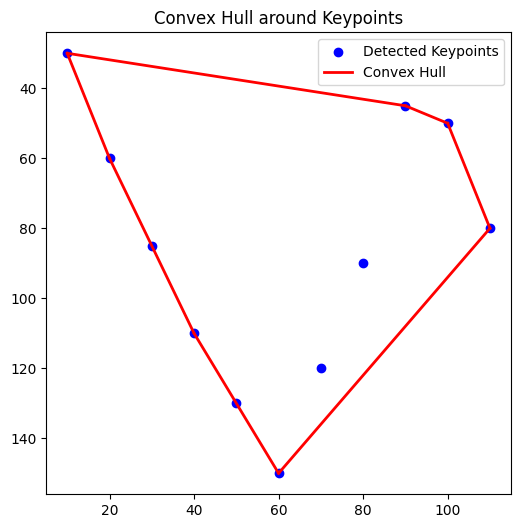

In [6]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def fit_polygon_and_visualize(keypoints):
    # Filter out [0, 0] keypoints (undetected points)
    detected_points = keypoints[np.any(keypoints != [0, 0], axis=1)]

    if len(detected_points) < 3:
        print("Not enough points to form a polygon.")
        return None

    # Compute the convex hull
    hull = ConvexHull(detected_points)
    polygon_points = detected_points[hull.vertices]

    # Plot keypoints and convex hull
    plt.figure(figsize=(6, 6))
    plt.scatter(detected_points[:, 0], detected_points[:, 1], color='blue', label='Detected Keypoints')
    
    # Draw the polygon
    for simplex in hull.simplices:
        plt.plot(detected_points[simplex, 0], detected_points[simplex, 1], 'r-', linewidth=2, label='Convex Hull' if simplex[0] == 0 else "")

    plt.gca().invert_yaxis()  # Optional: Flip y-axis if using image coordinates
    plt.legend()
    plt.title("Convex Hull around Keypoints")
    plt.show()

# Example usage:
keypoints = np.array([
    [100, 50], [0, 0], [110, 80], [90, 45], [0, 0], 
    [80, 90], [70, 120], [0, 0], [60, 150], [50, 130], 
    [0, 0], [40, 110], [30, 85], [20, 60], [0, 0], 
    [10, 30], [0, 0]
])

fit_polygon_and_visualize(keypoints)


/tmp/ipykernel_7676/1725973027.py:16: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)  # Convert to integer coordinates


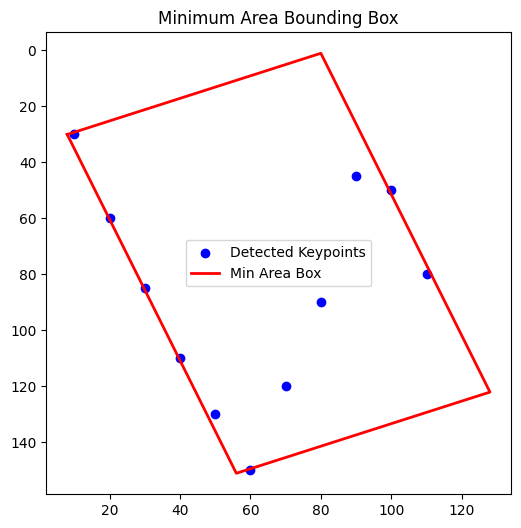

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_min_area_box(keypoints):
    # Filter out [0, 0] keypoints
    detected_points = keypoints[np.any(keypoints != [0, 0], axis=1)]

    if len(detected_points) < 3:
        print("Not enough points to form a polygon.")
        return None

    # Compute the minimum area bounding box
    rect = cv2.minAreaRect(detected_points.astype(np.float32))
    box = cv2.boxPoints(rect)
    box = np.int0(box)  # Convert to integer coordinates

    # Plot the keypoints and bounding box
    plt.figure(figsize=(6, 6))
    plt.scatter(detected_points[:, 0], detected_points[:, 1], color='blue', label='Detected Keypoints')
    plt.plot(np.append(box[:, 0], box[0, 0]), np.append(box[:, 1], box[0, 1]), 'r-', linewidth=2, label='Min Area Box')

    plt.gca().invert_yaxis()  # Optional: Flip y-axis for image coordinates
    plt.legend()
    plt.title("Minimum Area Bounding Box")
    plt.show()

# Example usage:
keypoints = np.array([
    [100, 50], [0, 0], [110, 80], [90, 45], [0, 0], 
    [80, 90], [70, 120], [0, 0], [60, 150], [50, 130], 
    [0, 0], [40, 110], [30, 85], [20, 60], [0, 0], 
    [10, 30], [0, 0]
])

visualize_min_area_box(keypoints)

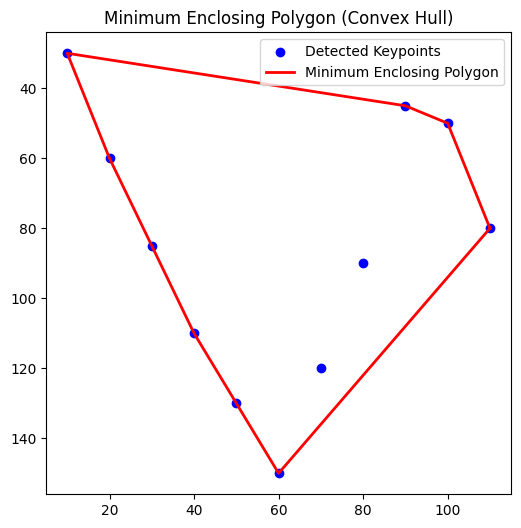

In [8]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def fit_polygon_and_visualize(keypoints):
    # Filter out [0, 0] keypoints (undetected points)
    detected_points = keypoints[np.any(keypoints != [0, 0], axis=1)]

    if len(detected_points) < 3:
        print("Not enough points to form a polygon.")
        return None

    # Compute the convex hull (polygon)
    hull = ConvexHull(detected_points)
    polygon_points = detected_points[hull.vertices]

    # Plot keypoints
    plt.figure(figsize=(6, 6))
    plt.scatter(detected_points[:, 0], detected_points[:, 1], color='blue', label='Detected Keypoints')

    # Plot the polygon (convex hull)
    plt.plot(
        np.append(polygon_points[:, 0], polygon_points[0, 0]),  # Close the polygon
        np.append(polygon_points[:, 1], polygon_points[0, 1]),
        'r-', linewidth=2, label='Minimum Enclosing Polygon'
    )

    # Optional: Flip y-axis to match image coordinates
    plt.gca().invert_yaxis()
    plt.legend()
    plt.title("Minimum Enclosing Polygon (Convex Hull)")
    plt.show()

# Example usage:
keypoints = np.array([
    [100, 50], [0, 0], [110, 80], [90, 45], [0, 0], 
    [80, 90], [70, 120], [0, 0], [60, 150], [50, 130], 
    [0, 0], [40, 110], [30, 85], [20, 60], [0, 0], 
    [10, 30], [0, 0]
])

fit_polygon_and_visualize(keypoints)


IoU of the two polygons: 0.14


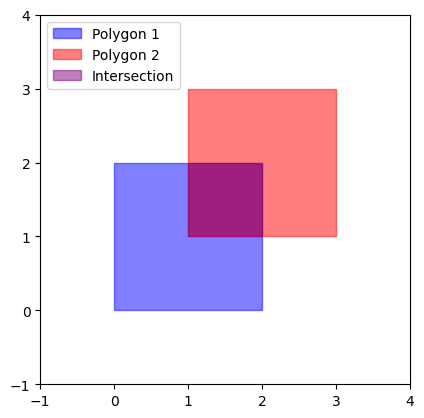

In [9]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union
from matplotlib.patches import Polygon as MplPolygon

def calculate_polygon_iou(polygon1, polygon2):
    # Create Polygon objects
    poly1 = Polygon(polygon1)
    poly2 = Polygon(polygon2)

    # Ensure the polygons are valid
    if not poly1.is_valid or not poly2.is_valid:
        raise ValueError("One or both polygons are invalid.")

    # Calculate intersection and union areas
    intersection_area = poly1.intersection(poly2).area
    union_area = poly1.union(poly2).area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou, poly1, poly2

def visualize_polygons(poly1, poly2):
    # Plot the two polygons
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # Add the polygons to the plot
    poly1_patch = MplPolygon(list(poly1.exterior.coords), alpha=0.5, color='blue', label='Polygon 1')
    poly2_patch = MplPolygon(list(poly2.exterior.coords), alpha=0.5, color='red', label='Polygon 2')
    ax.add_patch(poly1_patch)
    ax.add_patch(poly2_patch)

    # Plot the intersection area if it exists
    intersection = poly1.intersection(poly2)
    if not intersection.is_empty:
        intersection_patch = MplPolygon(list(intersection.exterior.coords), alpha=0.5, color='purple', label='Intersection')
        ax.add_patch(intersection_patch)

    # Set plot limits
    min_x, min_y, max_x, max_y = unary_union([poly1, poly2]).bounds
    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)

    # Add legend and show plot
    plt.legend()
    plt.show()

# Example usage:
polygon1 = [(0, 0), (2, 0), (2, 2), (0, 2)]  # Square
polygon2 = [(1, 1), (3, 1), (3, 3), (1, 3)]  # Overlapping square

iou, poly1, poly2 = calculate_polygon_iou(polygon1, polygon2)
print(f"IoU of the two polygons: {iou:.2f}")

# Visualize the polygons and their intersection
visualize_polygons(poly1, poly2)


IoU of the two polygons: 0.57


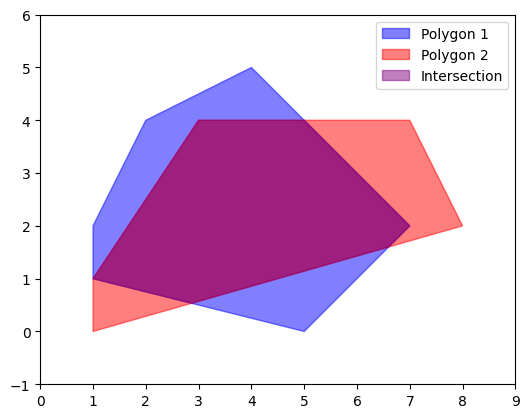

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPoint
from shapely.ops import unary_union
from matplotlib.patches import Polygon as MplPolygon

def filter_keypoints(keypoints):
    """Filter out [0, 0] keypoints from the array."""
    return [point for point in keypoints if not np.all(point == [0, 0])]

def create_polygon_from_keypoints(keypoints):
    """Create a valid polygon from filtered keypoints."""
    filtered_points = filter_keypoints(keypoints)
    if len(filtered_points) < 3:
        raise ValueError("Not enough valid keypoints to form a polygon.")

    # Use MultiPoint to ensure a valid convex hull
    polygon = MultiPoint(filtered_points).convex_hull

    # Apply buffer(0) to fix potential topology issues
    return polygon.buffer(0)

def calculate_polygon_iou(polygon1, polygon2):
    """Calculate the IoU between two polygons."""
    intersection_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area
    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou

def visualize_polygons(poly1, poly2):
    """Visualize two polygons and their intersection."""
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # Plot polygons
    poly1_patch = MplPolygon(list(poly1.exterior.coords), alpha=0.5, color='blue', label='Polygon 1')
    poly2_patch = MplPolygon(list(poly2.exterior.coords), alpha=0.5, color='red', label='Polygon 2')
    ax.add_patch(poly1_patch)
    ax.add_patch(poly2_patch)

    # Plot intersection area
    intersection = poly1.intersection(poly2)
    if not intersection.is_empty:
        intersection_patch = MplPolygon(list(intersection.exterior.coords), alpha=0.5, color='purple', label='Intersection')
        ax.add_patch(intersection_patch)

    # Set plot limits
    min_x, min_y, max_x, max_y = unary_union([poly1, poly2]).bounds
    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)

    plt.legend()
    plt.show()

# Example usage:
keypoints1 = np.array([
    [0, 0], [1, 2], [3, 1], [0, 0], [2, 4], [4, 3], [5, 0], 
    [0, 0], [2, 2], [1, 1], [3, 3], [0, 0], [4, 5], [0, 0], 
    [6, 1], [7, 2], [0, 0]
])

# keypoints1 = np.array([
#     [0, 0], [1, 2], [3, 1], [0, 0], [2, 4], [4, 3], [5, 0], 
#     [0, 0], [2, 2], [1, 1], [3, 3], [0, 0], [4, 5], [0, 0], 
#     [6, 1], [7, 2], [0, 0]
# ])

keypoints2 = np.array([
    [0, 0], [1, 1], [2, 2], [0, 0], [3, 4], [4, 2], [0, 0], 
    [5, 3], [6, 2], [0, 0], [2, 1], [3, 3], [0, 0], [7, 4], 
    [8, 2], [0, 0], [1, 0]
])

# Create polygons from keypoints
poly1 = create_polygon_from_keypoints(keypoints1)
poly2 = create_polygon_from_keypoints(keypoints2)

# Calculate IoU
iou = calculate_polygon_iou(poly1, poly2)
print(f"IoU of the two polygons: {iou:.2f}")

# Visualize the polygons and their intersection
visualize_polygons(poly1, poly2)


In [6]:
import numpy as np
array= np.array([[1, 2, 3, 4]])
array_2 = np.array([[5,6,7,8]])

array = np.concatenate((array, array_2))
array

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [2]:
from shapely.geometry import Polygon
import numpy as np

def calculate_polygon_iou_matrix(predictions, detections):
    """
    Calculate the IoU matrix between two sets of polygons.
    
    Args:
        predictions (list of Polygon): List of prediction polygons.
        detections (list of Polygon): List of detection polygons.
        
    Returns:
        np.ndarray: IoU matrix of shape (len(predictions), len(detections)).
    """
    # Initialize an empty matrix to store IoUs
    iou_matrix = np.zeros((len(predictions), len(detections)))

    # Calculate IoU for each pair of prediction and detection
    for i, pred in enumerate(predictions):
        for j, det in enumerate(detections):
            intersection_area = pred.intersection(det).area
            union_area = pred.union(det).area
            iou_matrix[i, j] = intersection_area / union_area if union_area > 0 else 0.0

    return iou_matrix

# Example usage
predictions = [
    Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]),
    Polygon([(1, 1), (3, 1), (3, 3), (1, 3)]),
    Polygon([(2, 2), (4, 2), (4, 4), (2, 4)]),
    Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]),
    Polygon([(1, 2), (2, 2), (2, 3), (1, 3)])
]

detections = [
    Polygon([(0, 0), (3, 0), (3, 3), (0, 3)]),
    Polygon([(2, 2), (5, 2), (5, 5), (2, 5)]),
    Polygon([(1, 0), (2, 0), (2, 1), (1, 1)]),
    Polygon([(0, 1), (2, 1), (2, 2), (0, 2)]),
    Polygon([(1, 2), (3, 2), (3, 4), (1, 4)]),
    Polygon([(3, 0), (4, 0), (4, 1), (3, 1)]),
    Polygon([(2, 3), (3, 3), (3, 4), (2, 4)])
]

# Calculate the IoU matrix
iou_matrix = calculate_polygon_iou_matrix(predictions, detections)
print("IoU Matrix:")
print(iou_matrix)


IoU Matrix:
[[0.44444444 0.         0.25       0.5        0.         0.
  0.        ]
 [0.44444444 0.08333333 0.         0.2        0.33333333 0.
  0.        ]
 [0.08333333 0.44444444 0.         0.         0.33333333 0.
  0.25      ]
 [0.11111111 0.         0.         0.         0.         0.
  0.        ]
 [0.11111111 0.         0.         0.         0.25       0.
  0.        ]]


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(predictions, detections):
    """
    Calculate the cosine similarity between each prediction and detection.

    Args:
        predictions (list of np.ndarray): List of pose estimates from predictions, 
                                          each of shape (17, 2).
        detections (list of np.ndarray): List of pose estimates from detections, 
                                         each of shape (17, 2).
    
    Returns:
        np.ndarray: Cosine similarity matrix of shape (len(predictions), len(detections)).
    """
    # Flatten each (17, 2) pose matrix to a (1, 34) vector for cosine similarity calculation
    pred_vectors = np.array([pred.flatten() for pred in predictions])
    det_vectors = np.array([det.flatten() for det in detections])

    # Calculate cosine similarity between each pair of prediction and detection
    similarity_matrix = cosine_similarity(pred_vectors, det_vectors)
    
    return similarity_matrix

# Example usage
# Assume we have 5 predictions and 4 detections, each with a (17, 2) pose matrix
# predictions = [np.random.rand(17, 2) for _ in range(5)]
# detections = [np.random.rand(17, 2) for _ in range(4)]

predictions = [np.zeros(17, 2) for _ in range(5)]
detections = [np.zeros(17, 2) for _ in range(4)]

similarity_matrix = calculate_cosine_similarity(predictions, detections)
print("Cosine Similarity Matrix:\n", similarity_matrix)


Cosine Similarity Matrix:
 [[0.78338931 0.66229046 0.72597942 0.73597899]
 [0.6779931  0.75474247 0.75977578 0.74544112]
 [0.77868333 0.79068746 0.75579272 0.81046758]
 [0.67009174 0.60382177 0.73769058 0.7326413 ]
 [0.74387994 0.75157814 0.76272935 0.77148707]]


In [11]:
import numpy as np
array = np.array([[[1,2,3,4], [4,5,6,7], [5,6,7,8], [6,7,8,9]],
                  [[10,20,30,40], [40,50,60,70], [50,60,70,80], [60,70,80,90]]])

bboxes_list = []
bboxes_list.append([[tracklet[:-1]] for tracklet in array]) 
bboxes_list

prediction_list = []
prediction_list.append([[tracklet[-1]] for tracklet in array])
prediction_list

[[[array([6, 7, 8, 9])], [array([60, 70, 80, 90])]]]

In [12]:
import numpy as np

def calculate_corner_angles(bbox1, bbox2):
    """
    Calculate the angle of change for each corner between two bounding box predictions.

    Args:
        bbox1, bbox2 (numpy array): Bounding boxes in the format [x_min, y_min, x_max, y_max].

    Returns:
        numpy array: A 1D array of angles (in radians) for each corner.
    """
    # Define corners of each bounding box
    corners1 = np.array([
        [bbox1[0], bbox1[1]],  # Top-left
        [bbox1[2], bbox1[1]],  # Top-right
        [bbox1[0], bbox1[3]],  # Bottom-left
        [bbox1[2], bbox1[3]]   # Bottom-right
    ])
    
    corners2 = np.array([
        [bbox2[0], bbox2[1]],  # Top-left
        [bbox2[2], bbox2[1]],  # Top-right
        [bbox2[0], bbox2[3]],  # Bottom-left
        [bbox2[2], bbox2[3]]   # Bottom-right
    ])
    
    # Calculate the direction vector for each corner
    direction_vectors = corners2 - corners1
    
    # Calculate angle using arctan2 (result in radians)
    angles = np.arctan2(direction_vectors[:, 1], direction_vectors[:, 0])
    
    return angles

# Example usage
bbox1 = np.array([621.12, 379.54, 845.48, 1011.2], dtype=np.float32)
bbox2 = np.array([772.4, 309.33, 1037.7, 1075.8], dtype=np.float32)

corner_angles = calculate_corner_angles(bbox1, bbox2)
print("Angle of change for each corner (radians):\n", corner_angles)


Angle of change for each corner (radians):
 [-0.43452266 -0.35020316  0.4035828   0.32421467]


In [ ]:
import numpy as np

# Example function to calculate prediction confidences from tracklet history
def calculate_prediction_confidence(tracklet):
    # Calculate based on area, aspect ratio, and movement stability
    areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in tracklet]
    aspect_ratios = [(box[2] - box[0]) / (box[3] - box[1]) for box in tracklet]
    centers = [[(box[0] + box[2]) / 2, (box[1] + box[3]) / 2] for box in tracklet]
    
    area_variance = np.var(areas)
    print(" area variance is : ", area_variance)
    aspect_ratio_variance = np.var(aspect_ratios)
    center_movements = [np.linalg.norm(np.array(centers[i]) - np.array(centers[i-1])) for i in range(1, len(centers))]
    center_movement_variance = np.var(center_movements)

    confidence = 1 - (0.3 * area_variance + 0.3 * aspect_ratio_variance + 0.4 * center_movement_variance)
    return max(0, confidence)

# Function to create the cost matrix
def create_confidence_cost_matrix(predictions, detections, detection_confidences):
    num_predictions = len(predictions)
    num_detections = len(detections)
    cost_matrix = np.zeros((num_predictions, num_detections))

    # Step 1: Calculate prediction confidences
    prediction_confidences = [calculate_prediction_confidence(tracklet) for tracklet in predictions]
    print(" prediction confidences are : ", prediction_confidences)
    # Step 2: Calculate cost for each prediction-detection pair
    for i, pred_conf in enumerate(prediction_confidences):
        for j, det_conf in enumerate(detection_confidences):
            # Define cost as a function of both prediction and detection confidence
            combined_confidence = (pred_conf + det_conf) / 2
            cost_matrix[i, j] = 1 - combined_confidence  # Lower cost for higher confidence

    # Step 3: Clip values to ensure valid range (optional)
    cost_matrix = np.clip(cost_matrix, 0, 1)
    
    return cost_matrix


# Example inputs
# Create a list of predictions (tracklets), each with several bounding boxes
predictions = [
    [[10, 20, 50, 60], [12, 22, 52, 62], [14, 24, 54, 64]],  # Tracklet 1
    [[100, 120, 150, 160], [102, 122, 152, 162], [104, 124, 154, 164]],  # Tracklet 2
    [[200, 220, 250, 260], [202, 222, 252, 262], [204, 224, 254, 264]]  # Tracklet 3
]

# Detections with confidence scores
detections = [
    [15, 25, 55, 65],  # Detection 1
    [105, 122, 155, 165],  # Detection 2
    [210, 230, 256, 270]  # Detection 3
]

# Confidence scores for detections
detection_confidences = [0.9, 0.8, 0.85]

# Calculate cost matrix
cost_matrix = create_confidence_cost_matrix(predictions, detections, detection_confidences)

# Display results
print("Prediction Confidences:", [calculate_prediction_confidence(tracklet) for tracklet in predictions])
print("Cost Matrix:\n", cost_matrix)


 prediction confidences are :  [1.0, 1.0, 1.0]
Prediction Confidences: [1.0, 1.0, 1.0]
Cost Matrix:
 [[0.05  0.1   0.075]
 [0.05  0.1   0.075]
 [0.05  0.1   0.075]]


In [14]:
import numpy as np

# detections = np.array([[20, 30, 60, 80] ,[50, 50, 100, 100], [15, 40, 55, 85],  [70, 10, 90, 40], [5, 5, 60, 60]])

predictions = np.array([[21, 31, 59, 79],[51, 55, 99, 98],[14, 42, 56, 84] , [75, 15, 88, 35]  , [7, 7, 58, 58] ,[15, 41, 57, 83]  ,[17, 43, 58, 82]])


def expand_boxes(boxes, buffer_size):
    modified_boxes = []

    for det in boxes:
        x_top, y_top, x_bottom, y_bottom = det
        
        # Calculate width and height
        width = x_bottom - x_top
        height = y_bottom - y_top
        # print("width is : " , width)
        # print("height is :", height)
        # Calculate buffer adjustments
        x_top_new = x_top - (buffer_size/2) * width
        y_top_new = y_top - (buffer_size)/2 * height
        x_bottom_new = x_bottom + (buffer_size)/2 * width
        y_bottom_new = y_bottom + (buffer_size)/2 * height
        
        
        new_width = x_bottom_new - x_top_new
        new_height = y_bottom_new - y_top_new
        buffer_scale = (new_width - width) / width
        print("buffer scale is : ", buffer_scale)
        
        # Append the modified detection
        modified_boxes.append([x_top_new, y_top_new, x_bottom_new, y_bottom_new])

    return np.array(modified_boxes)

predictions_buffered = expand_boxes(predictions, 0.3)
predictions_buffered


buffer scale is :  0.30000000000000016
buffer scale is :  0.3000000000000001
buffer scale is :  0.2999999999999999
buffer scale is :  0.30000000000000043
buffer scale is :  0.3000000000000002
buffer scale is :  0.2999999999999999
buffer scale is :  0.3000000000000001


array([[ 15.3 ,  23.8 ,  64.7 ,  86.2 ],
       [ 43.8 ,  48.55, 106.2 , 104.45],
       [  7.7 ,  35.7 ,  62.3 ,  90.3 ],
       [ 73.05,  12.  ,  89.95,  38.  ],
       [ -0.65,  -0.65,  65.65,  65.65],
       [  8.7 ,  34.7 ,  63.3 ,  89.3 ],
       [ 10.85,  37.15,  64.15,  87.85]])